# Nichesphere tutorial

Nichesphere is an sc-verse [ref] compatible Python library which allows the user to find differentially colocalised cellular niches based on cell type pairs colocalisation probabilities in different conditions. Cell type pair colocalisation probabilities are obtained from deconvoluted spatial transcriptomics / PIC-seq data (probabilities of finding each cell type in each spot / multiplet).

It also offers the possibility to look at localised differential cell - cell communication based on Ligand-Receptor pairs expression data, such as results from CrossTalkeR [ref].


## Libraries and functions

In [1]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import networkx as nx
import warnings
import scanpy as sc
import leidenalg
import igraph as ig
warnings.filterwarnings("ignore")

## My package test
import sys
sys.path.append("/home/mayra/source/Nichesphere/nichesphere/")
import nichesphere.tl

Accordion [ref] functions for distances

In [2]:

def get_Q_matrix(M):
    # taken from https://github.com/zboyd2/hitting_probabilities_metric/blob/master/HittingTimes_L3.m
    N = M.shape[0]
    e1 = np.zeros((1, N))
    e1[0][0] = 1
    A1inv = np.eye(N) - M
    A1inv[0, :] = e1
    A1inv = np.linalg.inv(A1inv)
    Q = np.zeros((N, N),dtype='double')
    Q[:, 0] = A1inv[:, 0].reshape(N,) / np.diagonal(A1inv)
    M = M @ A1inv
    detCj = ((1 + np.diagonal(M)) * (1 - M[0, 0])) + np.multiply(M[:, 0],M[0, :].transpose()).reshape(N,)
    CjInv = np.zeros((2, 2, N))
    CjInv[0, 0, :] = (1 - M[0, 0]) / detCj
    CjInv[0, 1, :] = M[:, 0].reshape(N,) / detCj # WAS WRONG INDEX HERE
    CjInv[1, 0, :] = -M[0, :].transpose().reshape(N,) / detCj
    CjInv[1, 1, :] = (1 + np.diagonal(M)) / detCj
    M1 = np.zeros((N, 2, N),dtype='double')
    M1[:, 0, :] = A1inv
    M1[:, 1, :] = np.tile(-A1inv[:, 0],( 1, N)).reshape(N, N)
    M2 = np.zeros((2, N, N),dtype='double')
    M2[0, :, :] = M.transpose()
    M2[1, :, :] = np.tile(M[0, :],(N, 1)).transpose()
    for j in range(1, N):
        # assert np.all(
        #    np.concatenate([A1inv[:, j].reshape((N, 1)), - A1inv[:, 0].reshape((N, 1))], axis=1) == M1[:, :, j])
        Ac = A1inv[:, j].reshape(N,) - np.matmul(np.matmul(M1[:, :, j], CjInv[:, :, j]), M2[:, j, j])
        Ad = np.diagonal(A1inv) - sum(
            M1[:, :, j].transpose() * np.matmul(CjInv[:, :, j], M2[:, :, j]))
        Q[:, j] = Ac / Ad
    np.fill_diagonal(Q, 0)
    return Q  # - np.diagonal(np.diagonal(Q))

In [3]:
### Get distances with accordion
def get_dhp(P, beta=0.5):
    n = P.shape[0]
    # Compute hitting probabilities
    Q = np.round(get_Q_matrix(P),5)
    # Find the invariant measure
    v = eigs(P.T.astype('f'), 
              k=1, 
              sigma=1+1e-6, 
              which='LM',
              tol=1e-3,maxiter=100000,v0=np.ones(n)/n)[1].ravel()
    v1 = np.abs(v)/norm(v,ord=1)
    #v = v-np.min(v) + 1e-10
    # Construct the symmetric adjacency matrix M:
    if beta == 0.5:
        Aht = diags(v1**0.5, 0,(n, n)) @ Q @ diags(v1**-0.5, 0,(n, n))
    elif beta == 1:
        Aht = diags(v1, 0,(n, n)) @ Q 
    else:
        raise ValueError(f"Unsupported beta value: {beta}")
    Aht = (Aht + Aht.T) / 2
    #np.fill_diagonal(Aht, 0)   
    # Compute the hitting probability distance
    dhp = -np.log10(Aht,where=Aht != 0)
    np.fill_diagonal(dhp,0)
    return(np.round(dhp,5)) 

## Data at first glance

Deconvoluted data (AnnData objects with reconstructed gene expression per spot and cell type proportions per spot as obs)

In [4]:
visiumFiles = glob.glob('./resulting_data/recAD_*.h5ad')

In [5]:
## Color

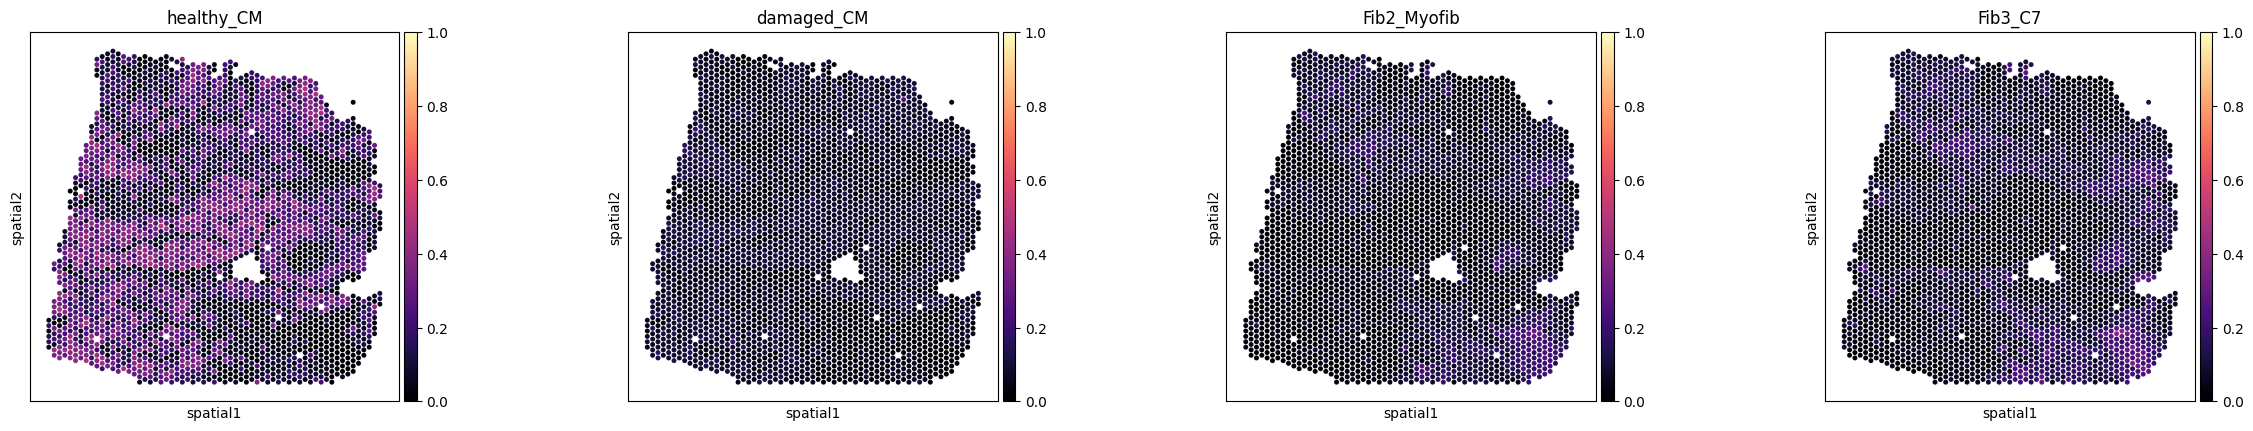

In [6]:
## Example
reconst_adata=sc.read('./resulting_data/recAD_FZ_P14.h5ad')

sc.pl.spatial(reconst_adata, color=['healthy_CM', 'damaged_CM', 'Fib2_Myofib', 'Fib3_C7'], spot_size=0.015, 
                  components=['1,2'], color_map='magma', vmin=0, vmax=1, img_key=None)

## Colocalisation

We will compute colocalisation probabilities from deconvoluted data files

Here we will get concatenated single colocalisation sample matrices of cell type x cell type.

In [7]:
CTcolocalizationP= nichesphere.tl.getColocProbs(filesList=visiumFiles, filePrefix='./resulting_data/recAD_', nCellTypes=33)
CTcolocalizationP

Adipo  Arterial_Endo  CCL18_Macrophages      CD_4  \
Adipo              4.853010e-07       0.000018           0.000002  0.000003   
Arterial_Endo      1.829922e-05       0.001238           0.000081  0.000222   
CCL18_Macrophages  1.598758e-06       0.000081           0.000014  0.000017   
CD_4               3.400817e-06       0.000222           0.000017  0.000047   
CD_8               1.592115e-06       0.000103           0.000008  0.000022   
...                         ...            ...                ...       ...   
prolif             4.497084e-06       0.000206           0.000024  0.000011   
vCM_3              4.527153e-06       0.000157           0.000016  0.000009   
vCM_4              1.848005e-06       0.000061           0.000006  0.000004   
vSMCs_1            1.067284e-05       0.000677           0.000059  0.000032   
vSMCs_2            6.692368e-06       0.000407           0.000035  0.000019   

                       CD_8  Capillary_Endo  Endocardial_Endo  Fib1_SCARA5  \
Adipo              0.000002        0.000047          0.000004     0.000045   
Arterial_Endo      0.000103        0.003159          0.000284     0.002427   
CCL18_Macrophages  0.000008        0.000205          0.000020     0.000195   
CD_4               0.000022        0.000572          0.000053     0.000469   
CD_8               0.000010        0.000267          0.000025     0.000217   
...                     ...             ...               ...          ...   
prolif             0.000007        0.000498          0.000140     0.000307   
vCM_3              0.000006        0.000409          0.000086     0.000127   
vCM_4              0.000002        0.000160          0.000033     0.000049   
vSMCs_1            0.000019        0.001480          0.000439     0.000690   
vSMCs_2            0.000012        0.000929          0.000252     0.000421   

                   Fib2_Myofib   Fib3_C7  ...  damaged_CM  healthy_CM  \
Adipo                 0.000046  0.000049  ...    0.000024    0.000111   
Arterial_Endo         0.002541  0.002587  ...    0.001153    0.005108   
CCL18_Macrophages     0.000206  0.000212  ...    0.000078    0.000348   
CD_4                  0.000488  0.000491  ...    0.000218    0.000955   
CD_8                  0.000227  0.000228  ...    0.000101    0.000445   
...                        ...       ...  ...         ...         ...   
prolif                0.000471  0.000487  ...    0.000083    0.000322   
vCM_3                 0.000168  0.000186  ...    0.000187    0.000833   
vCM_4                 0.000065  0.000073  ...    0.000077    0.000339   
vSMCs_1               0.000998  0.001083  ...    0.000222    0.000842   
vSMCs_2               0.000598  0.000664  ...    0.000151    0.000585   

                   intermediate_CM  perivascular_fibroblasts    prolif  \
Adipo                     0.000071                  0.000001  0.000007   
Arterial_Endo             0.003372                  0.000085  0.000412   
CCL18_Macrophages         0.000225                  0.000006  0.000043   
CD_4                      0.000634                  0.000015  0.000083   
CD_8                      0.000295                  0.000007  0.000039   
...                            ...                       ...       ...   
prolif                    0.000298                  0.000021  0.000020   
vCM_3                     0.000766                  0.000008  0.000010   
vCM_4                     0.000313                  0.000003  0.000004   
vSMCs_1                   0.000793                  0.000133  0.000052   
vSMCs_2                   0.000550                  0.000056  0.000030   

                      vCM_3     vCM_4   vSMCs_1   vSMCs_2    sample  
Adipo              0.000010  0.000004  0.000002  0.000002     RZ_P6  
Arterial_Endo      0.000468  0.000183  0.000177  0.000158     RZ_P6  
CCL18_Macrophages  0.000032  0.000012  0.000011  0.000010     RZ_P6  
CD_4               0.000088  0.000034  0.000028  0.000027     RZ_P6  
CD_8               0.000

Same cell type interactions will be excluded later on, so we'll have a list of same cell type interaction pairs in order to subset the colocalisation table we'll generate in the next step.

In [8]:
oneCTints=CTcolocalizationP.columns[range(len(CTcolocalizationP.columns)-1)]+'-'+CTcolocalizationP.columns[range(len(CTcolocalizationP.columns)-1)]

Then we will reshape the colocalisation data into a matrix of cell type pairs x samples

In [9]:
colocPerSample=nichesphere.tl.reshapeColoc(CTcoloc=CTcolocalizationP, oneCTinteractions=oneCTints, complete=0)
colocPerSample.to_csv('./colocPerSample.csv')
colocPerSample

Adipo-Adipo  Adipo-Arterial_Endo  Adipo-CCL18_Macrophages  \
RZ_P6        4.853010e-07             0.000037                 0.000003   
IZ_P15       1.966656e-07             0.000016                 0.000017   
FZ_GT_P4     1.126579e-05             0.000474                 0.000010   
RZ_BZ_P2     1.105628e-06             0.000088                 0.000009   
GT_IZ_P15    5.767664e-04             0.000286                 0.000233   
control_P17  6.289654e-07             0.000034                 0.000008   
GT_IZ_P13    2.642507e-06             0.000076                 0.000197   
RZ_P3        6.800323e-03             0.000527                 0.000189   
control_P8   2.772405e-06             0.000087                 0.000011   
RZ_P9        2.076141e-06             0.000076                 0.000023   
FZ_P20       3.545350e-03             0.000541                 0.001062   
FZ_P14       6.720036e-06             0.000170                 0.000049   
control_P7   8.982178e-07             0.000040                 0.000004   
GT_IZ_P9     1.504257e-05             0.000438                 0.000060   
RZ_GT_P2     4.283639e-06             0.000167                 0.000038   
control_P1   4.278044e-07             0.000042                 0.000006   
RZ_BZ_P3     4.880486e-06             0.000077                 0.000028   
FZ_P18       2.865277e-03             0.003038                 0.002217   
RZ_BZ_P12    7.230729e-07             0.000054                 0.000010   
IZ_P10       2.357683e-06             0.000070                 0.000044   
FZ_GT_P19    1.079043e-06             0.000040                 0.000113   
RZ_P11       2.149479e-06             0.000080                 0.000014   
RZ_FZ_P5     5.629996e-06             0.000108                 0.000021   

             Adipo-CD_4    Adipo-CD_8  Adipo-Capillary_Endo  \
RZ_P6          0.000007  3.184230e-06              0.000093   
IZ_P15         0.000001  3.760164e-07              0.000020   
FZ_GT_P4       0.000005  3.328752e-06              0.000989   
RZ_BZ_P2       0.000011  3.494129e-06              0.000178   
GT_IZ_P15      0.000071  1.785958e-05              0.000593   
control_P17    0.000009  7.743603e-06              0.000082   
GT_IZ_P13      0.000054  5.672618e-05              0.000074   
RZ_P3          0.000293  1.135053e-04              0.001024   
control_P8     0.000017  9.010965e-06              0.000226   
RZ_P9          0.000009  1.141184e-05              0.000191   
FZ_P20         0.000636  4.896802e-04              0.000580   
FZ_P14         0.000018  8.646106e-06              0.000385   
control_P7     0.000008  3.014409e-06              0.000089   
GT_IZ_P9       0.000041  3.946400e-06              0.000504   
RZ_GT_P2       0.000040  2.033120e-05              0.000447   
control_P1     0.000004  3.663171e-06              0.000074   
RZ_BZ_P3       0.000026  1.420825e-05              0.000138   
FZ_P18         0.001904  1.815740e-03              0.004426   
RZ_BZ_P12      0.000030  2.031383e-05              0.000115   
IZ_P10         0.000020  3.193144e-06              0.000148   
FZ_GT_P19      0.000041  2.191911e-05              0.000075   
RZ_P11         0.000019  8.569242e-06              0.000209   
RZ_FZ_P5       0.000006  3.461814e-06              0.000266   

             Adipo-Endocardial_Endo  Adipo-Fib1_SCARA5  Adipo-Fib2_Myofib  \
RZ_P6                      0.000009           0.000090           0.000092   
IZ_P15                     0.000008           0.000029           0.000234   
FZ_GT_P4                   0.000094           0.000195           0.000903   
RZ_BZ_P2                   0.000018           0.000098           0.000093   
GT_IZ_P15                  0.000162           0.000329           0.001412   
control_P17                0.000041           0.000058           0.000074   
GT_IZ_P13                  0.000062           0.000101           0.000431   
RZ_P3                      0.000846           0.003447           0.005006   
control

The sum of the probabilities of every cell type pair in a sample must be = 1

In [10]:
colocPerSample.sum(axis=1)

RZ_P6          1.0
IZ_P15         1.0
FZ_GT_P4       1.0
RZ_BZ_P2       1.0
GT_IZ_P15      1.0
control_P17    1.0
GT_IZ_P13      1.0
RZ_P3          1.0
control_P8     1.0
RZ_P9          1.0
FZ_P20         1.0
FZ_P14         1.0
control_P7     1.0
GT_IZ_P9       1.0
RZ_GT_P2       1.0
control_P1     1.0
RZ_BZ_P3       1.0
FZ_P18         1.0
RZ_BZ_P12      1.0
IZ_P10         1.0
FZ_GT_P19      1.0
RZ_P11         1.0
RZ_FZ_P5       1.0
dtype: float64

Conditions

To subset the samples, we will have this dataframe of sample names and conditions. In this case, condition can be inferred from the sample name

In [11]:
sampleTypesDF=pd.DataFrame(colocPerSample.index, columns=['sample'])
sampleTypesDF['sampleType']='myogenic'

#tmp.obs.sampleType[tmp.obs['sample'].str.contains("BZ")]='border'
sampleTypesDF.sampleType[sampleTypesDF['sample'].str.contains("RZ")]='remote'
sampleTypesDF.sampleType[sampleTypesDF['sample'].str.contains("BZ")]='border'


sampleTypesDF.sampleType[sampleTypesDF['sample'].str.contains("FZ")]='fibrotic'
sampleTypesDF.sampleType[sampleTypesDF['sample'].str.contains("IZ")]='ischemic'
sampleTypesDF

sample sampleType
0         RZ_P6     remote
1        IZ_P15   ischemic
2      FZ_GT_P4   fibrotic
3      RZ_BZ_P2     border
4     GT_IZ_P15   ischemic
5   control_P17   myogenic
6     GT_IZ_P13   ischemic
7         RZ_P3     remote
8    control_P8   myogenic
9         RZ_P9     remote
10       FZ_P20   fibrotic
11       FZ_P14   fibrotic
12   control_P7   myogenic
13     GT_IZ_P9   ischemic
14     RZ_GT_P2     remote
15   control_P1   myogenic
16     RZ_BZ_P3     border
17       FZ_P18   fibrotic
18    RZ_BZ_P12     border
19       IZ_P10   ischemic
20    FZ_GT_P19   fibrotic
21       RZ_P11     remote
22     RZ_FZ_P5   fibrotic

Differential colocalisation analysis

We will test differential colocalisation between two different conditions using Wilcoxon tests

In [12]:
## Differential colocalisation

pvals_myo_isc=[scipy.stats.ranksums(colocPerSample.loc[colocPerSample.index[sampleTypesDF.sampleType=='ischemic'],c], 
                                    colocPerSample.loc[colocPerSample.index[sampleTypesDF.sampleType=='myogenic'],c]).pvalue for c in colocPerSample.columns]
stat_myo_isc=[scipy.stats.ranksums(colocPerSample.loc[colocPerSample.index[sampleTypesDF.sampleType=='ischemic'],c], 
                                    colocPerSample.loc[colocPerSample.index[sampleTypesDF.sampleType=='myogenic'],c]).statistic for c in colocPerSample.columns]


myo_iscDF=pd.DataFrame([colocPerSample.columns, stat_myo_isc, pvals_myo_isc], index=['pairs', 'statistic', 'p-value']).T
#myo_iscDF=myo_iscDF.sort_values(['p-value'])
myo_iscDF.index=myo_iscDF.pairs
myo_iscDF

pairs statistic   p-value
pairs                                                               
Adipo-Adipo                          Adipo-Adipo  0.979796  0.327187
Adipo-Arterial_Endo          Adipo-Arterial_Endo  0.979796  0.327187
Adipo-CCL18_Macrophages  Adipo-CCL18_Macrophages   2.44949  0.014306
Adipo-CD_4                            Adipo-CD_4  1.469694  0.141645
Adipo-CD_8                            Adipo-CD_8  0.244949  0.806496
...                                          ...       ...       ...
vCM_4-vSMCs_1                      vCM_4-vSMCs_1 -0.734847  0.462433
vCM_4-vSMCs_2                      vCM_4-vSMCs_2 -1.469694  0.141645
vSMCs_1-vSMCs_1                  vSMCs_1-vSMCs_1       0.0       1.0
vSMCs_1-vSMCs_2                  vSMCs_1-vSMCs_2 -0.244949  0.806496
vSMCs_2-vSMCs_2                  vSMCs_2-vSMCs_2 -1.469694  0.141645

[561 rows x 3 columns]

Cell groups 

We can define different cell groups and visualise them with different colors in the colocalisation network

In [13]:
parenchyme=['Adipo', 'damaged_CM', 'healthy_CM', 'intermediate_CM', 'vCM_3', 'vCM_4']
immune=['CCL18_Macrophages', 'CD_4', 'CD_8', 'LYVE_FOLR_Macrophages', 'LYVE_PLTP_Macrophages', 'Mast', 'Monocytes', 'NK', 'NK_T', 'SPP1_Macrophages']
stromal=['Arterial_Endo', 'Capillary_Endo', 'Endocardial_Endo', 'Fib3_C7', 'Fib4_COL15A1', 'Fib1_SCARA5', 'Lymphatic_Endo', 'Fib2_Myofib', 'Neuronal', 'Pericyte_1', 'Pericyte_2', 
         'Purkinje_fibers', 'Venous_Endo', 'perivascular_fibroblasts', 'vSMCs_1', 'vSMCs_2']
cellGroups={'parenchyme':parenchyme, 'stromal':stromal, 'immune':immune}

Colocalisation network

To build the colocalisation network, we will first get a matrix of differential colocalisation scores (x_diff) and then an adjacency matrix (adj) based on the cosine similarities of the distributions of differential colocalisation scores for the different cell types

In [14]:
# The function creating the scores and adjacency matrices requires a cell type pairs data frame where the column containing the cell type pairs is called 'pairs' and cell type pairs are separated by an arrow ('->'):
pairsDir=[]
for ct in CTcolocalizationP.columns[range(len(CTcolocalizationP.columns)-1)]:
    for ct2 in CTcolocalizationP.columns[range(len(CTcolocalizationP.columns)-1)]:
        pairsDir.append(ct+'->'+ct2)

pairCatDFdir=pd.DataFrame(pairsDir, columns=['pairs'])
#pairCatDFdir.index=pairCatDFdir.pairs
pairCatDFdir

pairs
0                 Adipo->Adipo
1         Adipo->Arterial_Endo
2     Adipo->CCL18_Macrophages
3                  Adipo->CD_4
4                  Adipo->CD_8
...                        ...
1084           vSMCs_2->prolif
1085            vSMCs_2->vCM_3
1086            vSMCs_2->vCM_4
1087          vSMCs_2->vSMCs_1
1088          vSMCs_2->vSMCs_2

[1089 rows x 1 columns]

In [15]:
# generate scores and adjacency matrices
x_diff, adj=nichesphere.tl.getAdj_coloc(diffColocDF=myo_iscDF[myo_iscDF.pairs.str.contains('prolif')==False], pairCatDF=pairCatDFdir[pairCatDFdir.pairs.str.contains('prolif')==False],  ncells=32)

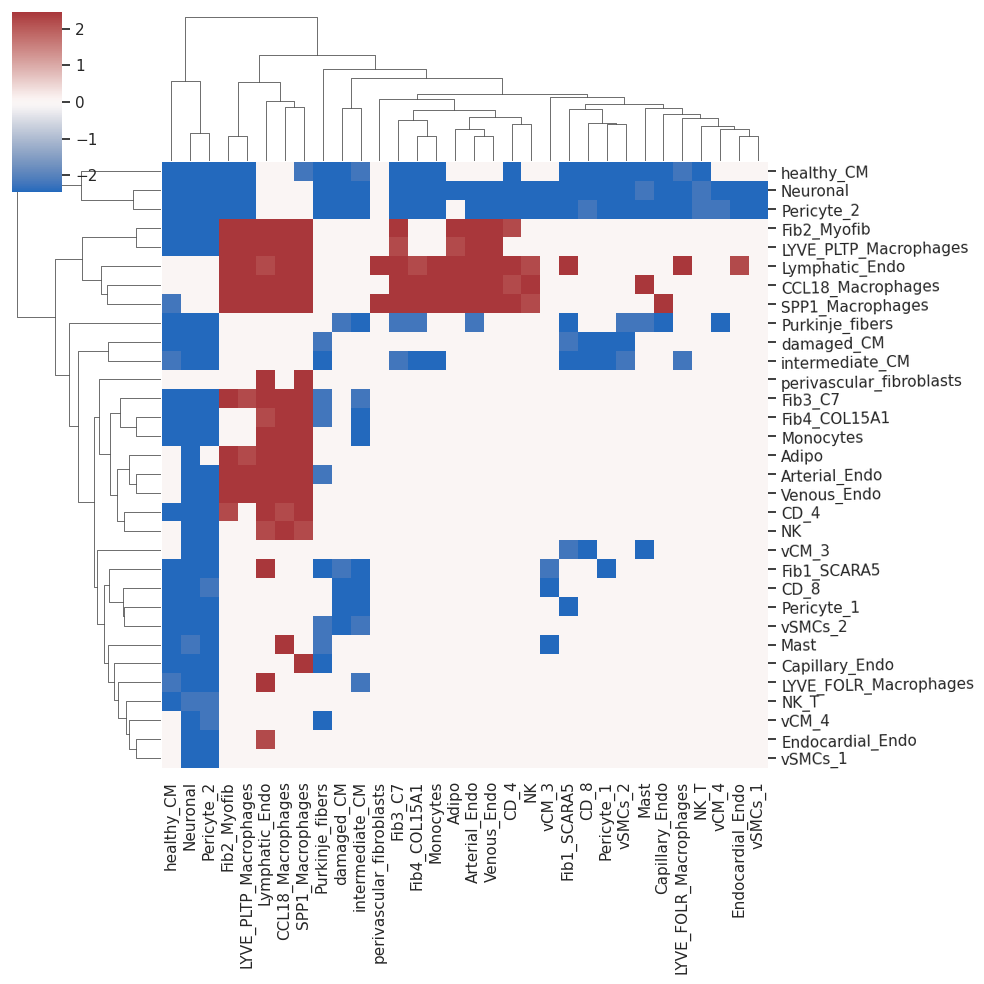

In [16]:
sns.set(font_scale=1)
plot=sns.clustermap(x_diff, cmap='vlag', center=0, method='average')
#plot.set_yticklabels(rotation=90)
plt.setp(plot.ax_heatmap.yaxis.get_majorticklabels(), rotation=1)
plt.show()

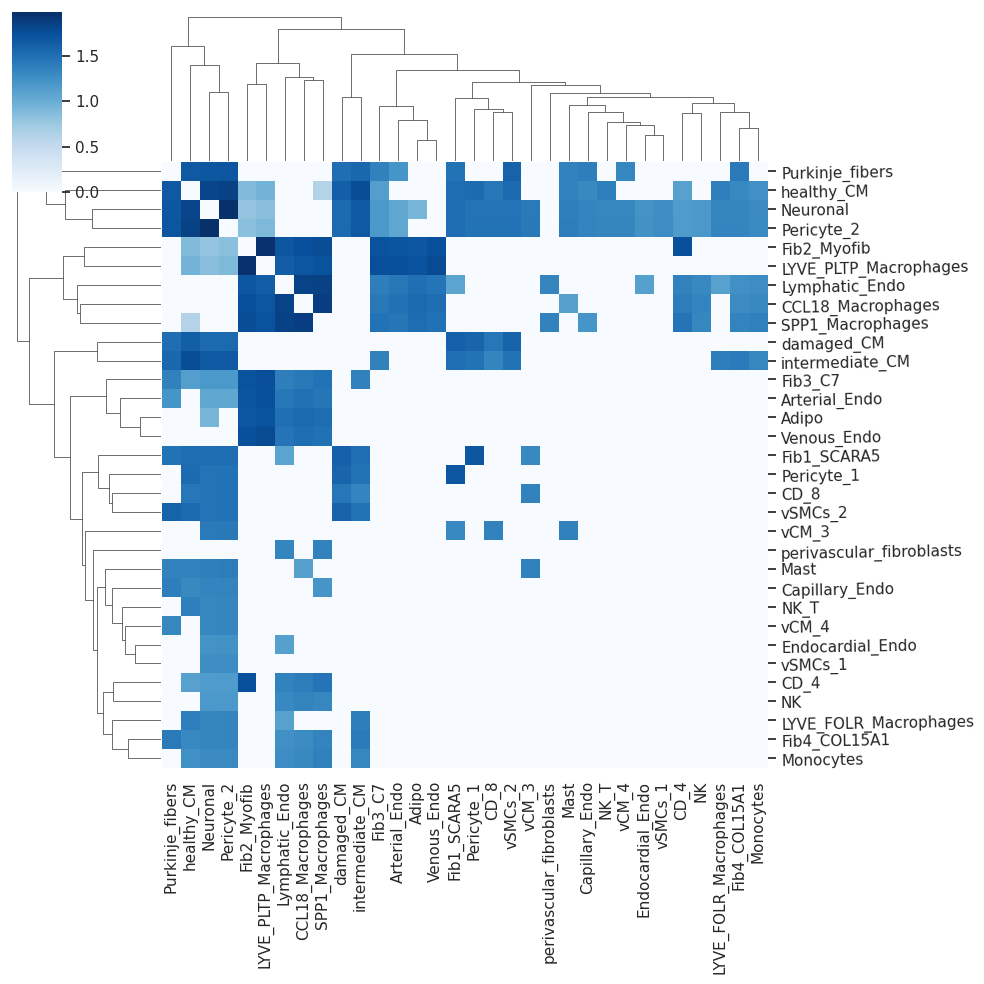

In [17]:
sns.set(font_scale=1)
plot=sns.clustermap(adj, cmap='Blues', method='average')
#plot.set_yticklabels(rotation=90)
plt.setp(plot.ax_heatmap.yaxis.get_majorticklabels(), rotation=1)
plt.show()

Then the network is built just taking into account the differentially colocalised cell type pairs. The cell groups dictionary can be used here to visualize different cell groups in different colors.

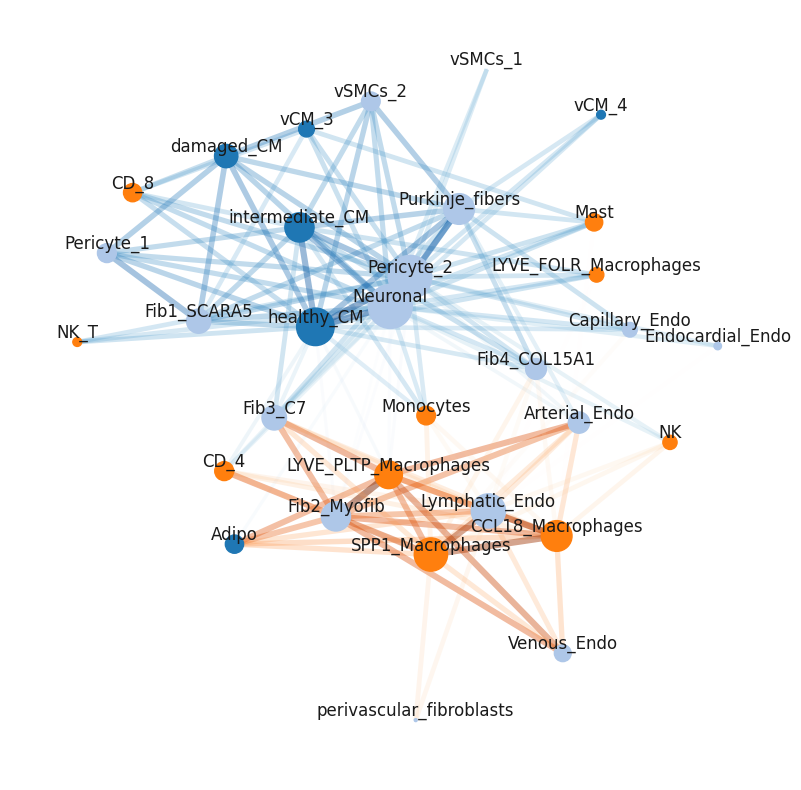

In [18]:
gCol=nichesphere.tl.colocNW(x_diff=x_diff, adj=adj,cell_group=cellGroups, group_cmap='tab20', ncols=20)

We can then calculate some network statistics with the networkX package [ref] functions:

In [19]:
columns=['influencer_score', 'betweenness', 'pagerank', 'degree']
index=list(gCol.nodes)

In [20]:
t1=pd.DataFrame({'influencer':[nx.eigenvector_centrality(gCol)[x] for x in list(gCol.nodes)], 'betweenness':[nx.betweenness_centrality(gCol)[x] for x in list(gCol.nodes)], 
                 'degree':[nx.degree_centrality(gCol)[x] for x in list(gCol.nodes)], 'pagerank':[nx.pagerank(gCol)[x] for x in list(gCol.nodes)]})
t1.index=list(gCol.nodes)
t1.sort_values('degree', ascending=False).to_csv('./coloc_nw_stats.csv')

And visualize them

<Axes: xlabel='pagerank'>

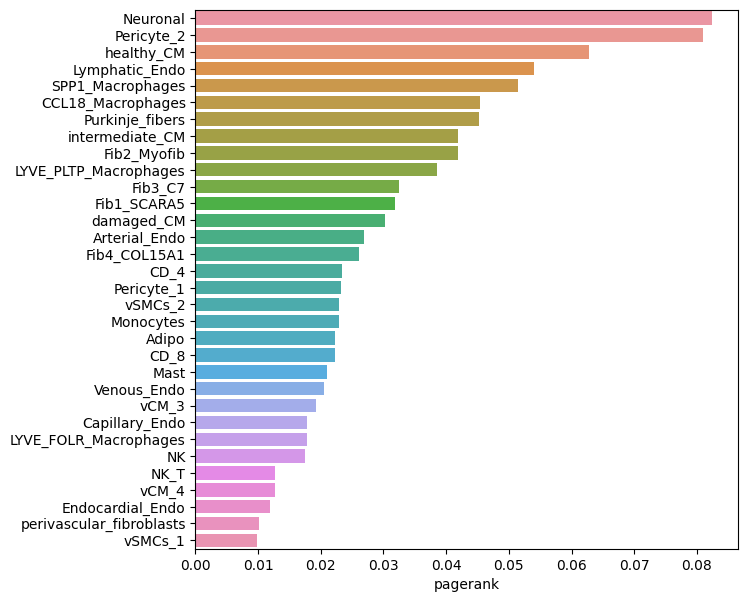

In [21]:
plt.style.use('default')
f,ax1 = plt.subplots(1,1,figsize=(7, 7),dpi=100) 
sns.barplot(y=t1.sort_values('pagerank', ascending=False).index, x='pagerank', data=t1.sort_values('pagerank', ascending=False))

<Axes: xlabel='influencer'>

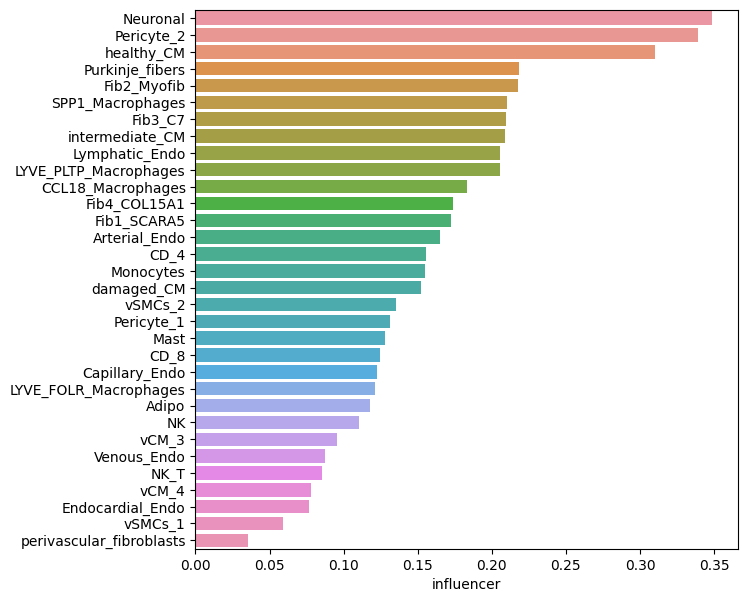

In [22]:
plt.style.use('default')
f,ax1 = plt.subplots(1,1,figsize=(7, 7),dpi=100) 
sns.barplot(y=t1.sort_values('influencer', ascending=False).index, x='influencer', data=t1.sort_values('influencer', ascending=False))

<Axes: xlabel='betweenness'>

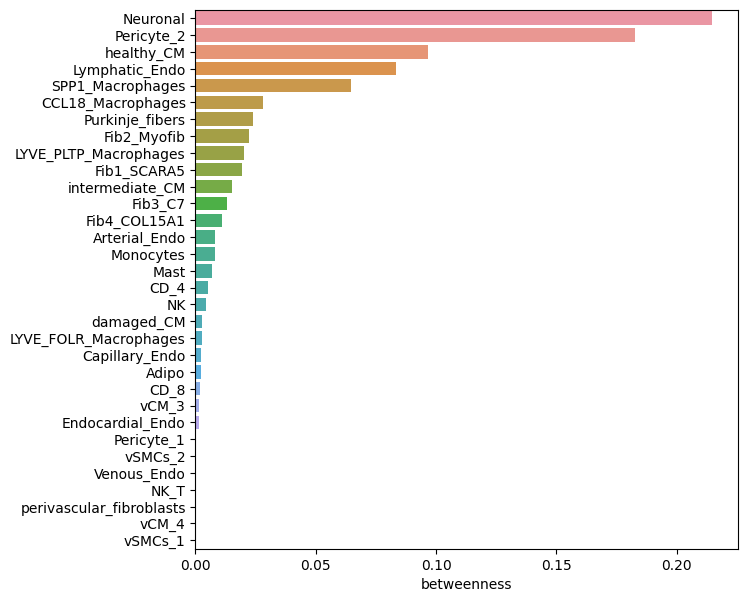

In [23]:
plt.style.use('default')
f,ax1 = plt.subplots(1,1,figsize=(7, 7),dpi=100) 
sns.barplot(y=t1.sort_values('betweenness', ascending=False).index, x='betweenness', data=t1.sort_values('betweenness', ascending=False))

To filter the communication data, we will make a binary vector indicating whether each cell type pair is differentially colocalised

In [24]:
colocFilt=nichesphere.tl.getColocFilter(pairCatDF=pairCatDFdir[pairCatDFdir.pairs.str.contains('prolif')==False], adj=adj, oneCTints=oneCTints[oneCTints.str.contains('prolif')==False].str.replace('-', '->'))
colocFilt.to_csv('./colocalisation_filter.csv')
colocFilt

filter
pairs                                    
Adipo->Adipo                          1.0
Adipo->Arterial_Endo                  0.0
Adipo->CCL18_Macrophages              1.0
Adipo->CD_4                           0.0
Adipo->CD_8                           0.0
...                                   ...
vSMCs_2->perivascular_fibroblasts     0.0
vSMCs_2->vCM_3                        0.0
vSMCs_2->vCM_4                        0.0
vSMCs_2->vSMCs_1                      0.0
vSMCs_2->vSMCs_2                      1.0

[1024 rows x 1 columns]

To find niches of differentially colocalised cell types, we can cluster the colocailsation network. Leiden clustering is used in this example

In [25]:
#### Coloc NW clustering
gCol_ig = ig.Graph.from_networkx(gCol)
#part = leidenalg.find_partition(gCol_ig, leidenalg.CPMVertexPartition, resolution_parameter=0.05)
#part = leidenalg.find_partition(gCol_ig, leidenalg.ModularityVertexPartition, 2, seed=7)
#colocClusts=pd.Series(part.membership, index=gCol.nodes)
## Leiden clusters dictionary
#leiden_cellGroups={'0':colocClusts[colocClusts==0].index, '1':colocClusts[colocClusts==1].index}

In [26]:
## Or clustering on adj
#### Clusters from clustermap on adj
heatClusts=scipy.cluster.hierarchy.fcluster(plot.dendrogram_col.linkage, 2, depth=6)
#heatClusts_cellGroups={'0':plot2.dendrogram_col.data.columns[heatClusts==1], '1':plot2.dendrogram_col.data.columns[heatClusts==2], 
#                       '2':plot2.dendrogram_col.data.columns[heatClusts==3], '3':plot2.dendrogram_col.data.columns[heatClusts==4]}
#### Clusters dictionary
heatClusts_cellGroups={'0':plot.dendrogram_col.data.columns[heatClusts==1], '1':plot.dendrogram_col.data.columns[heatClusts==2], 
                       '2':plot.dendrogram_col.data.columns[heatClusts==3]}
#### Clusters series
colocClusts=pd.Series(heatClusts, index=plot.dendrogram_col.data.columns)
colocClusts=colocClusts-1
#colocClusts[colocClusts==1]=0
#colocClusts[colocClusts==2]=1
colocClusts


Adipo                       2
Arterial_Endo               2
CCL18_Macrophages           1
CD_4                        2
CD_8                        2
Capillary_Endo              2
Endocardial_Endo            2
Fib1_SCARA5                 2
Fib2_Myofib                 1
Fib3_C7                     2
Fib4_COL15A1                2
LYVE_FOLR_Macrophages       2
LYVE_PLTP_Macrophages       1
Lymphatic_Endo              1
Mast                        2
Monocytes                   2
NK                          2
NK_T                        2
Neuronal                    0
Pericyte_1                  2
Pericyte_2                  0
Purkinje_fibers             0
SPP1_Macrophages            1
Venous_Endo                 2
damaged_CM                  2
healthy_CM                  0
intermediate_CM             2
perivascular_fibroblasts    2
vCM_3                       2
vCM_4                       2
vSMCs_1                     2
vSMCs_2                     2
dtype: int32

Now we can color the nodes in the network by niche

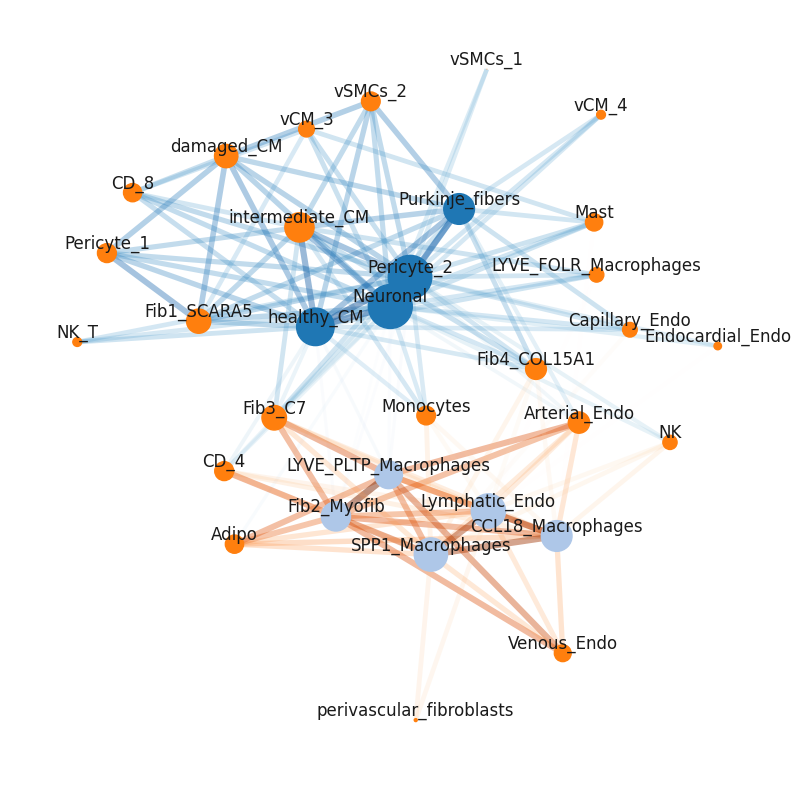

In [27]:
nichesphere.tl.colocNW(x_diff=x_diff, adj=adj,cell_group=heatClusts_cellGroups, group_cmap='tab20', ncols=20)

We can define different interaction categories depending on the interacting cell groups

In [28]:
#pairCatDFdir=pd.DataFrame(pairsDir, columns=['pairs'])

pairCatDFdir['colocCats']=''
pairCatDFdir['colocCats'][[nichesphere.tl.cellCatContained(pair=p, cellCat=colocClusts.index[colocClusts==0]) for p in pairCatDFdir.pairs]]='0->0'
pairCatDFdir['colocCats'][[nichesphere.tl.cellCatContained(pair=p, cellCat=colocClusts.index[colocClusts==1]) for p in pairCatDFdir.pairs]]='1->1'
pairCatDFdir['colocCats'][[nichesphere.tl.cellCatContained(pair=p, cellCat=colocClusts.index[colocClusts==2]) for p in pairCatDFdir.pairs]]='2->2'

pairCatDFdir['colocCats'][[(p.split('->')[0] in colocClusts.index[colocClusts==0]) & (p.split('->')[1] in colocClusts.index[colocClusts==1]) for p in pairCatDFdir.pairs]]='0->1'
pairCatDFdir['colocCats'][[(p.split('->')[1] in colocClusts.index[colocClusts==0]) & (p.split('->')[0] in colocClusts.index[colocClusts==1]) for p in pairCatDFdir.pairs]]='1->0'

pairCatDFdir['colocCats'][[(p.split('->')[0] in colocClusts.index[colocClusts==0]) & (p.split('->')[1] in colocClusts.index[colocClusts==2]) for p in pairCatDFdir.pairs]]='0->2'
pairCatDFdir['colocCats'][[(p.split('->')[1] in colocClusts.index[colocClusts==0]) & (p.split('->')[0] in colocClusts.index[colocClusts==2]) for p in pairCatDFdir.pairs]]='2->0'

pairCatDFdir['colocCats'][[(p.split('->')[0] in colocClusts.index[colocClusts==1]) & (p.split('->')[1] in colocClusts.index[colocClusts==2]) for p in pairCatDFdir.pairs]]='1->2'
pairCatDFdir['colocCats'][[(p.split('->')[1] in colocClusts.index[colocClusts==1]) & (p.split('->')[0] in colocClusts.index[colocClusts==2]) for p in pairCatDFdir.pairs]]='2->1'

#pairCatDFdir.index=pairCatDFdir.pairs
pairCatDFdir

pairs colocCats
0                 Adipo->Adipo      2->2
1         Adipo->Arterial_Endo      2->2
2     Adipo->CCL18_Macrophages      2->1
3                  Adipo->CD_4      2->2
4                  Adipo->CD_8      2->2
...                        ...       ...
1084           vSMCs_2->prolif      2->2
1085            vSMCs_2->vCM_3      2->2
1086            vSMCs_2->vCM_4      2->2
1087          vSMCs_2->vSMCs_1      2->2
1088          vSMCs_2->vSMCs_2      2->2

[1089 rows x 2 columns]

## **Communication**

Get cell communication data (CrossTalkeR tables)

In [29]:
#crossTalker_ctrlComm=pd.read_csv('./crossTalker_tbl_CTR.csv', index_col=0)
crossTalker_ctrlComm=pd.read_csv('./crossTalker_tbl_myo_heartV2.csv', index_col=0)
crossTalker_ctrlComm.cellpair=crossTalker_ctrlComm.source+'-'+crossTalker_ctrlComm.target
crossTalker_ctrlComm['gene_A']=crossTalker_ctrlComm['gene_A'].str.replace('\|L', '')
crossTalker_ctrlComm['gene_A']=crossTalker_ctrlComm['gene_A'].str.replace('\|R', '')
crossTalker_ctrlComm['gene_B']=crossTalker_ctrlComm['gene_B'].str.replace('\|R', '')
crossTalker_ctrlComm['gene_B']=crossTalker_ctrlComm['gene_B'].str.replace('\|TF', '')

#crossTalker_iscComm=pd.read_csv('./crossTalker_tbl_EXP.csv', index_col=0)
crossTalker_iscComm=pd.read_csv('./crossTalker_tbl_isc_heartV2.csv', index_col=0)
crossTalker_iscComm.cellpair=crossTalker_iscComm.source+'-'+crossTalker_iscComm.target
crossTalker_iscComm['gene_A']=crossTalker_iscComm['gene_A'].str.replace('\|L', '')
crossTalker_iscComm['gene_A']=crossTalker_iscComm['gene_A'].str.replace('\|R', '')
crossTalker_iscComm['gene_B']=crossTalker_iscComm['gene_B'].str.replace('\|R', '')
crossTalker_iscComm['gene_B']=crossTalker_iscComm['gene_B'].str.replace('\|TF', '')

Names of cell types need to match between communication and colocalisation data

In [30]:
crossTalker_ctrlComm=crossTalker_ctrlComm.replace({'Fib_0': 'Fib3_C7', 'Fib_3': 'Fib4_COL15A1', "Myofib": "Fib2_Myofib", "Fib_SCARA5":"Fib1_SCARA5", 'CD4': 'CD_4', 'CD8': 'CD_8'}, regex=True)

In [31]:
crossTalker_iscComm=crossTalker_iscComm.replace({'Fib_0': 'Fib3_C7', 'Fib_3': 'Fib4_COL15A1', "Myofib": "Fib2_Myofib", "Fib_SCARA5":"Fib1_SCARA5", 'CD4': 'CD_4', 'CD8': 'CD_8'}, regex=True)

In [32]:
crossTalker_ctrlComm

cellpair   source   target  gene_A  gene_B type_gene_A  \
1           Adipo-Adipo    Adipo    Adipo     AXL   HNF1A    Receptor   
2           Adipo-Adipo    Adipo    Adipo  BMPR1B   HNF1A    Receptor   
3           Adipo-Adipo    Adipo    Adipo     MET   HNF1A    Receptor   
4           Adipo-Adipo    Adipo    Adipo   BAMBI    RBPJ    Receptor   
5           Adipo-Adipo    Adipo    Adipo    EGFR    RBPJ    Receptor   
...                 ...      ...      ...     ...     ...         ...   
103592  vSMCs_2-vSMCs_2  vSMCs_2  vSMCs_2     NGF  MAGED1      Ligand   
103593  vSMCs_2-vSMCs_2  vSMCs_2  vSMCs_2    FGF1   CSPG4      Ligand   
103594  vSMCs_2-vSMCs_2  vSMCs_2  vSMCs_2    NTF3   NTRK3      Ligand   
103595  vSMCs_2-vSMCs_2  vSMCs_2  vSMCs_2    NTF3   NTRK2      Ligand   
103596  vSMCs_2-vSMCs_2  vSMCs_2  vSMCs_2   CALM1    MYLK      Ligand   

                 type_gene_B    MeanLR                         allpair  \
1       Transcription Factor  0.565849      Adipo/AXL|R@Adipo/HNF1A|TF   
2       Transcription Factor  0.565849   Adipo/BMPR1B|R@Adipo/HNF1A|TF   
3       Transcription Factor  0.565849      Adipo/MET|R@Adipo/HNF1A|TF   
4       Transcription Factor  0.432287     Adipo/BAMBI|R@Adipo/RBPJ|TF   
5       Transcription Factor  0.432287      Adipo/EGFR|R@Adipo/RBPJ|TF   
...                      ...       ...                             ...   
103592              Receptor  0.798947  vSMCs_2/NGF|L@vSMCs_2/MAGED1|R   
103593              Receptor  0.481052  vSMCs_2/FGF1|L@vSMCs_2/CSPG4|R   
103594              Receptor  0.463158  vSMCs_2/NTF3|L@vSMCs_2/NTRK3|R   
103595              Receptor  0.284211  vSMCs_2/NTF3|L@vSMCs_2/NTRK2|R   
103596              Receptor  0.363158  vSMCs_2/CALM1|L@vSMCs_2/MYLK|R   

                ligpair           recpair   LRScore  
1           Adipo/AXL|R    Adipo/HNF1A|TF  0.565849  
2        Adipo/BMPR1B|R    Adipo/HNF1A|TF  0.565849  
3           Adipo/MET|R    Adipo/HNF1A|TF  0.565849  
4         Adipo/BAMBI|R     Adipo/RBPJ|TF  0.432287  
5          Adipo/EGFR|R     Adipo/RBPJ|TF  0.432287  
...                 ...               ...       ...  
103592    vSMCs_2/NGF|L  vSMCs_2/MAGED1|R  0.798947  
103593   vSMCs_2/FGF1|L   vSMCs_2/CSPG4|R  0.481052  
103594   vSMCs_2/NTF3|L   vSMCs_2/NTRK3|R  0.463158  
103595   vSMCs_2/NTF3|L   vSMCs_2/NTRK2|R  0.284211  
103596  vSMCs_2/CALM1|L    vSMCs_2/MYLK|R  0.363158  

[103596 rows x 12 columns]

Load the tables from the different ligand databases and concatenate them

In [33]:
## matrissome
matrissome=pd.read_csv('/home/mayra/ligandDBs/matrissome/matrissomeDB_processed.csv', index_col=0)
matrissome.Ligand=matrissome.Ligand.str.lower()
matrissome=matrissome.drop_duplicates()
matrissome['db']='matrissome'

In [34]:
## cytosig
cytosig=pd.read_csv('/home/mayra/ligandDBs/cytosig/CytoSigDB_processed.csv', index_col=0)
#cytosig.Ligand=cytosig.Ligand.str.lower()
cytosig['db']='cytosig'
cytosig=cytosig[['Ligand', 'category', 'db']]

In [35]:
## together
allDBs=pd.concat([matrissome, cytosig])
allDBs

Ligand    category          db
1      gene   Collagens  matrissome
2    col1a1   Collagens  matrissome
5    col1a2   Collagens  matrissome
17   col6a3   Collagens  matrissome
23   col3a1   Collagens  matrissome
..      ...         ...         ...
526   PTGES  Inhibitory     cytosig
536   PTGS2  Inhibitory     cytosig
546   PTGS2  Inhibitory     cytosig
555   PTGS2  Inhibitory     cytosig
565   PTGS2  Inhibitory     cytosig

[1606 rows x 3 columns]

Then we'll calculate communication scores summing scores for a specific LR pair for a specific cell type pair and separate these scores per ligand category to know which cell type pairs are interacting through which mechanisms.

In [36]:
myoCTpairScores_byCat2_dir_colocClusts=nichesphere.tl.lr_ctPairScores_perCat_dir(ccommTable=crossTalker_ctrlComm.loc[crossTalker_ctrlComm.cellpair.str.contains('prolif')==False], db=allDBs, dbCatCol='category', dbMatchCol='Ligand', 
                        ccommMatchCol='gene_A', ccommLRscoresCol='MeanLR', oneCTinteractions=oneCTints, condition='myogenic', pairCatDF=pairCatDFdir)


In [37]:
iscCTpairScores_byCat2_dir_colocClusts=nichesphere.tl.lr_ctPairScores_perCat_dir(ccommTable=crossTalker_iscComm.loc[crossTalker_iscComm.cellpair.str.contains('prolif')==False], db=allDBs, dbCatCol='category', dbMatchCol='Ligand', 
                        ccommMatchCol='gene_A', ccommLRscoresCol='MeanLR', oneCTinteractions=oneCTints, condition='ischemic', pairCatDF=pairCatDFdir)


Some interactions might be present only in one condition, so we will assign 0 values to the interactions that do not appear in one condition to be able to compare conditions

In [38]:
myoCTpairScores_byCat2_dir_colocClusts, iscCTpairScores_byCat2_dir_colocClusts = nichesphere.tl.equalizeScoresTables(ctrlTbl=myoCTpairScores_byCat2_dir_colocClusts, 
                                                    expTbl=iscCTpairScores_byCat2_dir_colocClusts, ctrlCondition='myogenic', expCondition='ischemic')

Filter by colocalisation

In [39]:
myoCTpairScores_byCat2_dir_colocClusts=myoCTpairScores_byCat2_dir_colocClusts[[i in colocFilt.index[colocFilt['filter']==1] for i in myoCTpairScores_byCat2_dir_colocClusts.pairs]]
iscCTpairScores_byCat2_dir_colocClusts=iscCTpairScores_byCat2_dir_colocClusts[[i in colocFilt.index[colocFilt['filter']==1] for i in iscCTpairScores_byCat2_dir_colocClusts.pairs]]

Then we can test for differential cell cell communication across mechanisms and cell groups with the function 'tl.diffCcommStats' and plot the resulting scores as follows:

2->1      1->1      1->2       2->0       2->2      1->0  \
Collagens        0.000000  0.000000  0.000000 -29.344609  -6.217171 -6.748293   
ECMaffiliated   -8.163389 -7.169394 -7.499278  -9.798087  -4.957187 -4.082296   
ECMglycoprots    0.000000  0.000000 -2.907520 -20.033196   0.000000 -5.764662   
ECMregulators    0.000000  2.789731  0.000000 -18.663093  -5.698531 -3.664947   
Proteoglycans   -4.073934 -6.928587 -7.661705 -11.107266  -2.670814 -4.612741   
SecretedFactors -9.269008 -2.172986 -7.237040 -23.431601 -11.115001 -5.268124   
Chemokine       -2.025375 -1.995399  0.000000  -4.532640  -4.339061 -2.025641   
Cytokine        -6.308162 -3.021942 -5.893090  -8.829197  -2.770851 -5.026936   
GrowthFactor    -8.329931  0.000000 -3.023056 -21.925538 -10.381732 -3.862358   
Inhibitory       0.000000 -3.688845 -6.438559  -6.447078  -2.237111 -3.250494   

                      0->2      0->1       0->0  
Collagens       -34.442071 -8.370062 -23.159951  
ECMaffiliated   -13.613254 -4.014324  -6.320085  
ECMglycoprots   -24.652936 -5.136606 -16.859723  
ECMregulators   -20.631102 -7.884187 -12.406308  
Proteoglycans    -9.302542 -2.569340  -5.865532  
SecretedFactors -21.993718 -6.787167 -14.558282  
Chemokine        -8.874667 -2.321858  -5.093560  
Cytokine        -11.144184 -4.391986  -4.869943  
GrowthFactor    -19.830838 -5.655358 -13.319443  
Inhibitory       -2.061278  0.000000   0.000000

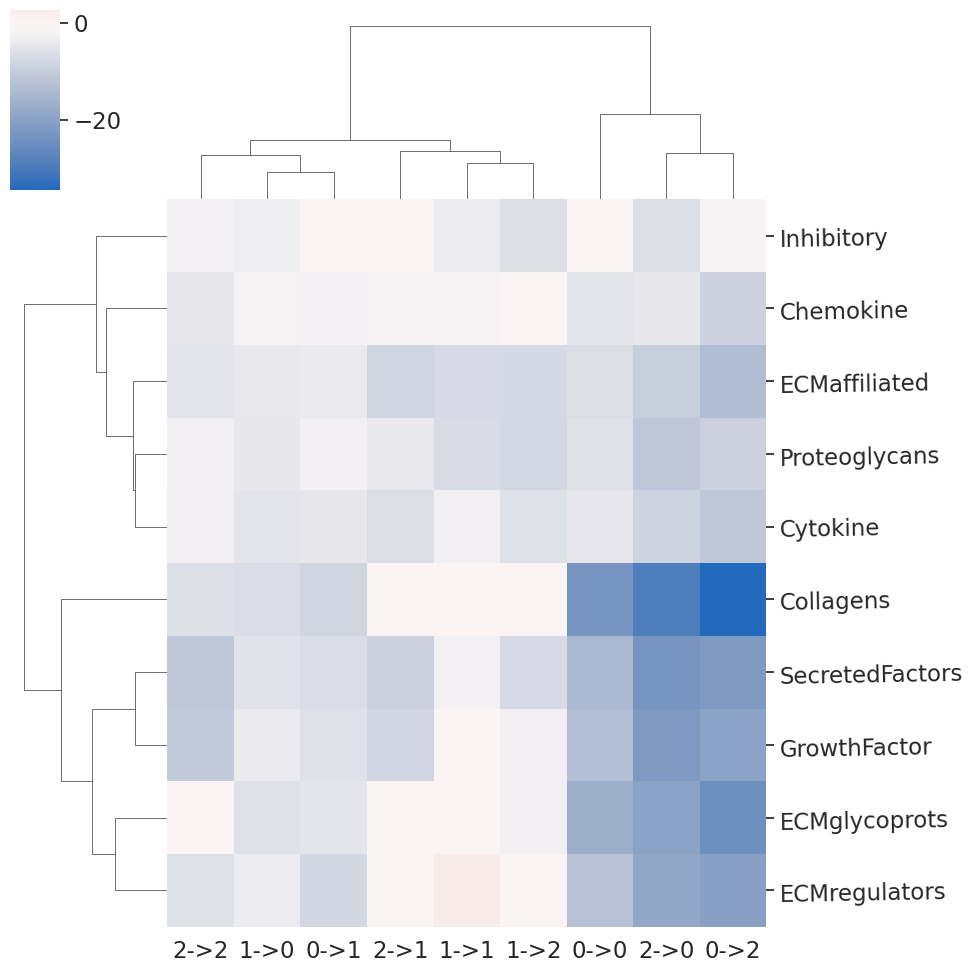

In [40]:
## Differential communication by coloc group

## Differential communication statistics
myoIsc_diffCcommTable_colocGroups_dir=nichesphere.tl.diffCcommStats(c1CTpairScores_byCat=iscCTpairScores_byCat2_dir_colocClusts, c2CTpairScores_byCat=myoCTpairScores_byCat2_dir_colocClusts, cellCatCol='colocCats')

## Plot in heatmap
nichesphere.tl.plotDiffCcommStatsHM(diffCommTable=myoIsc_diffCcommTable_colocGroups_dir, min_pval=0.05)

These statistics can also be shown in boxplots

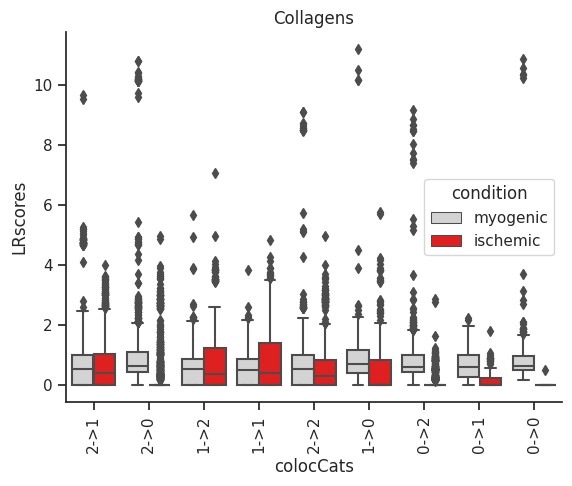

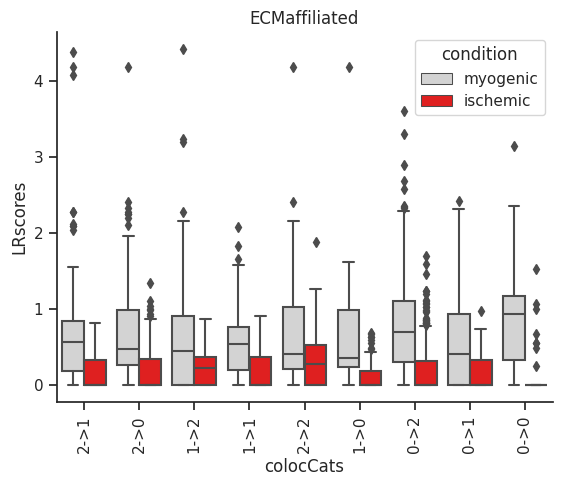

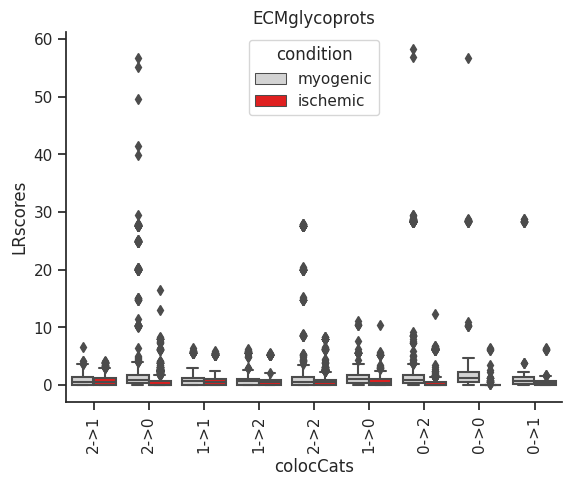

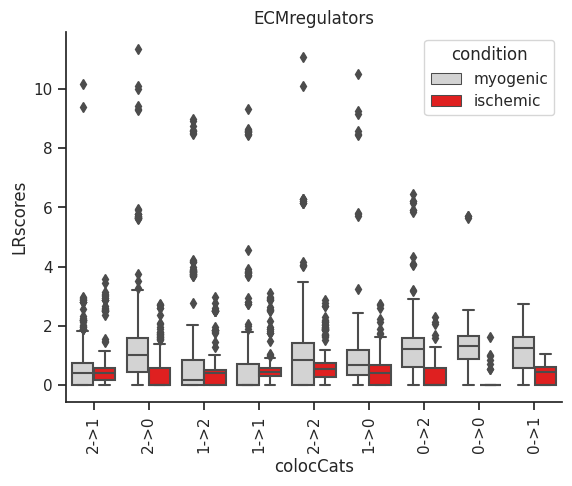

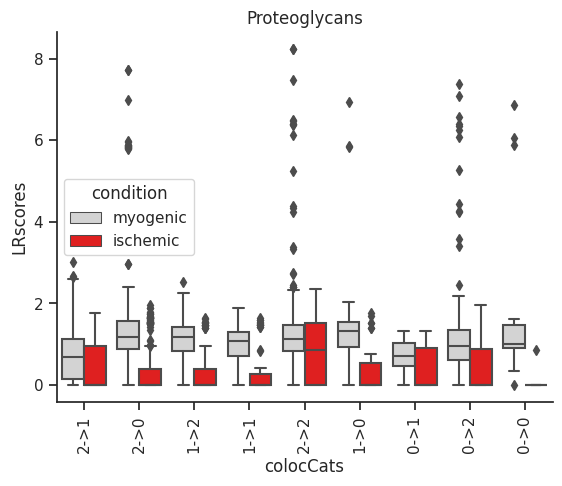

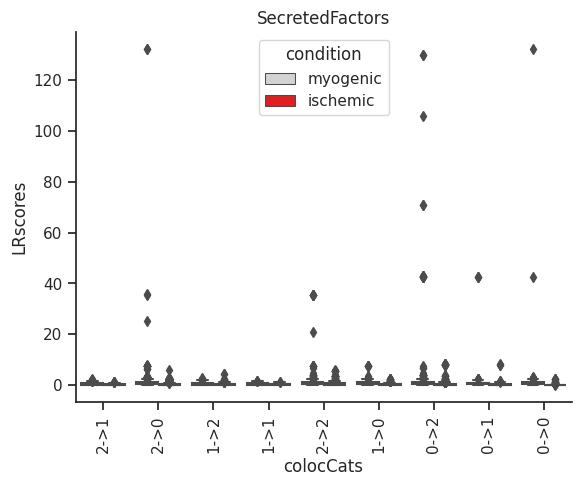

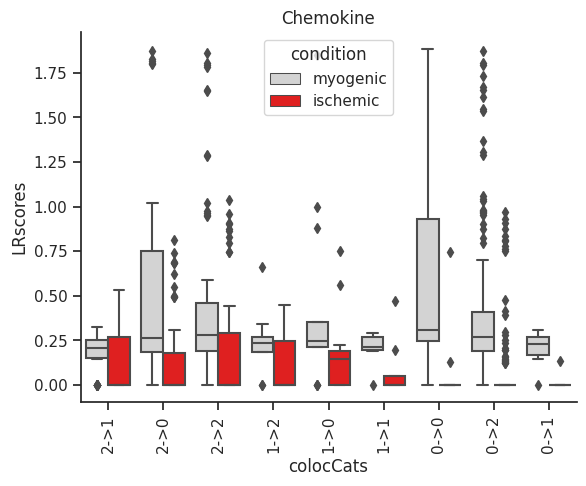

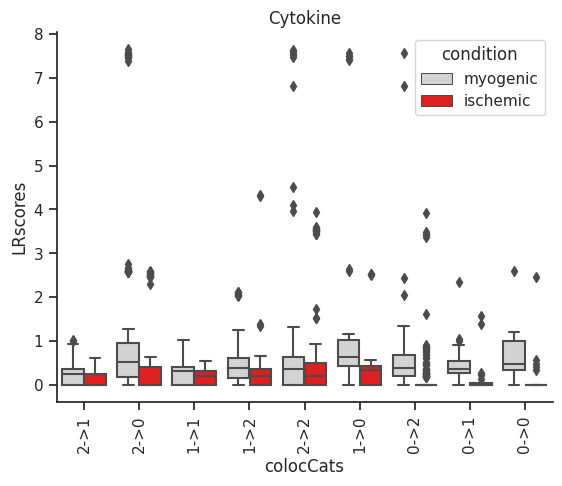

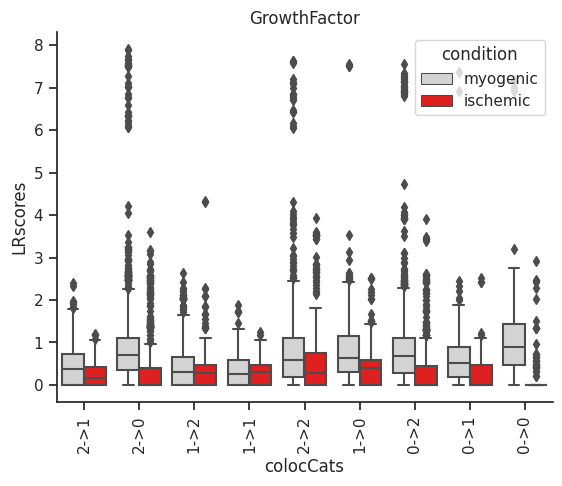

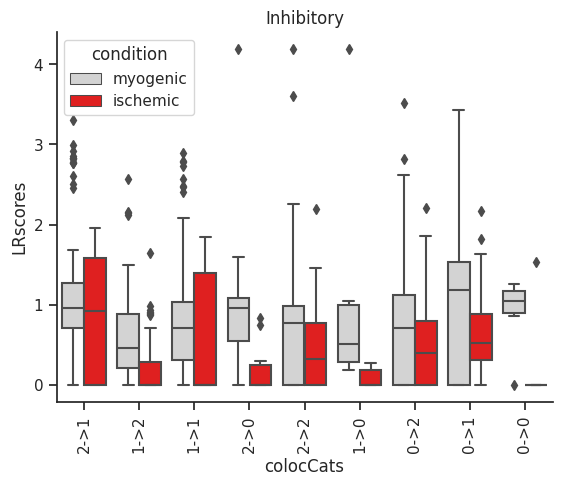

In [41]:
## First we concatenate the dataframes of statistics for each condition
boxplotDF=pd.concat([myoCTpairScores_byCat2_dir_colocClusts, iscCTpairScores_byCat2_dir_colocClusts])
#boxplotDF.to_csv('/home/mayra/wng2_wsm/ccomm_EV_x_thpo_cytosig.csv')
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
## Define a color per condition
my_colors = {'myogenic': 'lightgray', 'ischemic': 'red'}
## Then we can do boxplots for the different Ligand categories
for cat in boxplotDF.LRcat.unique():
    sns.set_theme(style="ticks", rc=custom_params)
    sns.boxplot(data=boxplotDF[boxplotDF.LRcat==cat], x='colocCats', y='LRscores', hue='condition', palette=my_colors, dodge=True).set(title=cat)
    plt.xticks(rotation=90)
    #plt.savefig('/home/mayra/wng2_wsm/diffCcomm_EV_x_thpo_'+cat+'.pdf', bbox_inches='tight')
    plt.show()

Next, we can look at differential cell communication per cell type pair in each ligand category

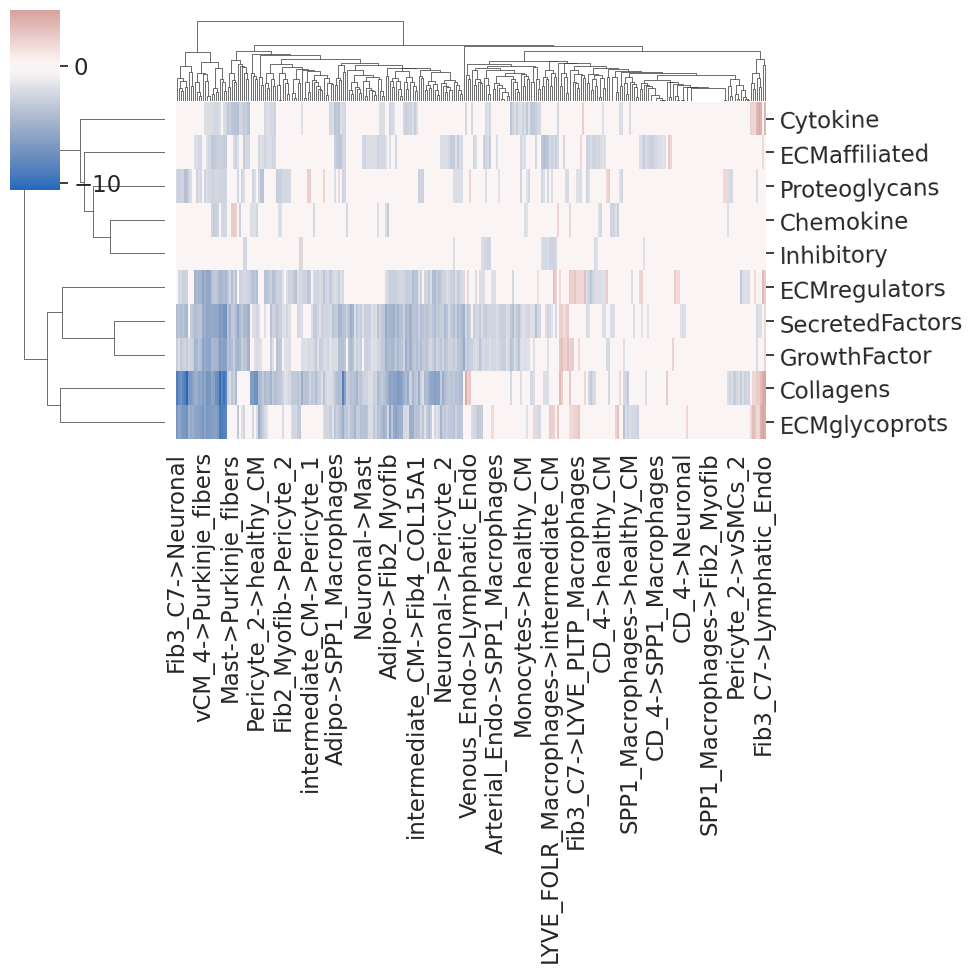

In [42]:
## Differential cell communication per cell type pair

## Differential communication statistics
myoIsc_diffCcommTable2_CTpair_dir=nichesphere.tl.diffCcommStats(c1CTpairScores_byCat=iscCTpairScores_byCat2_dir_colocClusts, c2CTpairScores_byCat=myoCTpairScores_byCat2_dir_colocClusts, cellCatCol='pairs')

## Plot in heatmap
x_myoIsc2_dir=nichesphere.tl.plotDiffCcommStatsHM(diffCommTable=myoIsc_diffCcommTable2_CTpair_dir, min_pval=0.1)

We can also plot Ligand-Receptor based cellular interactions per mechanism on the colocalisation network after filtering the communication data

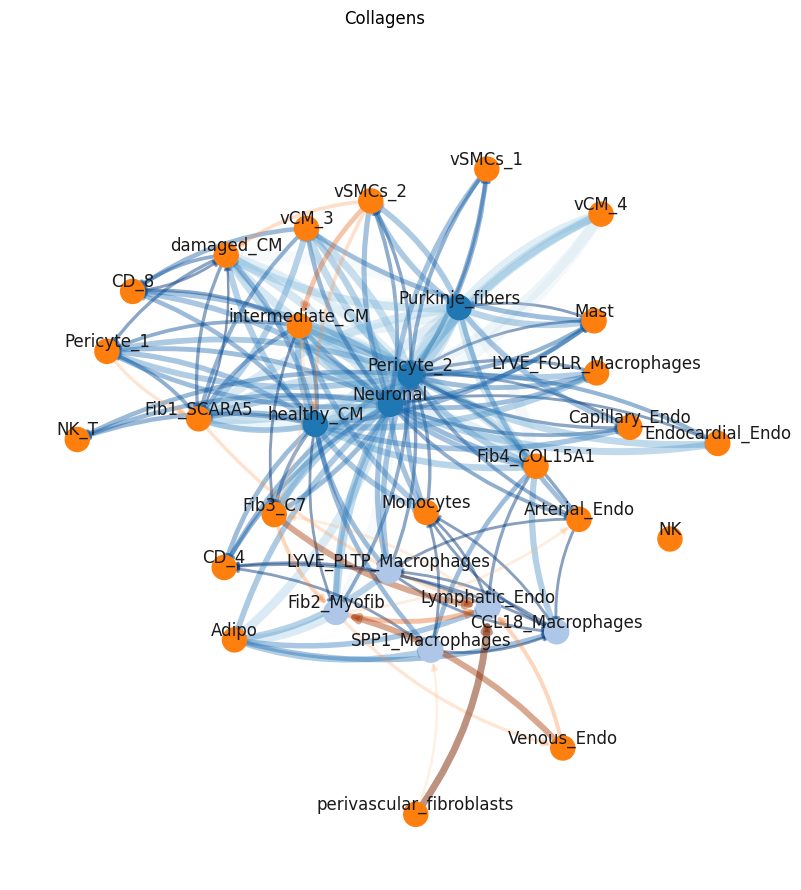

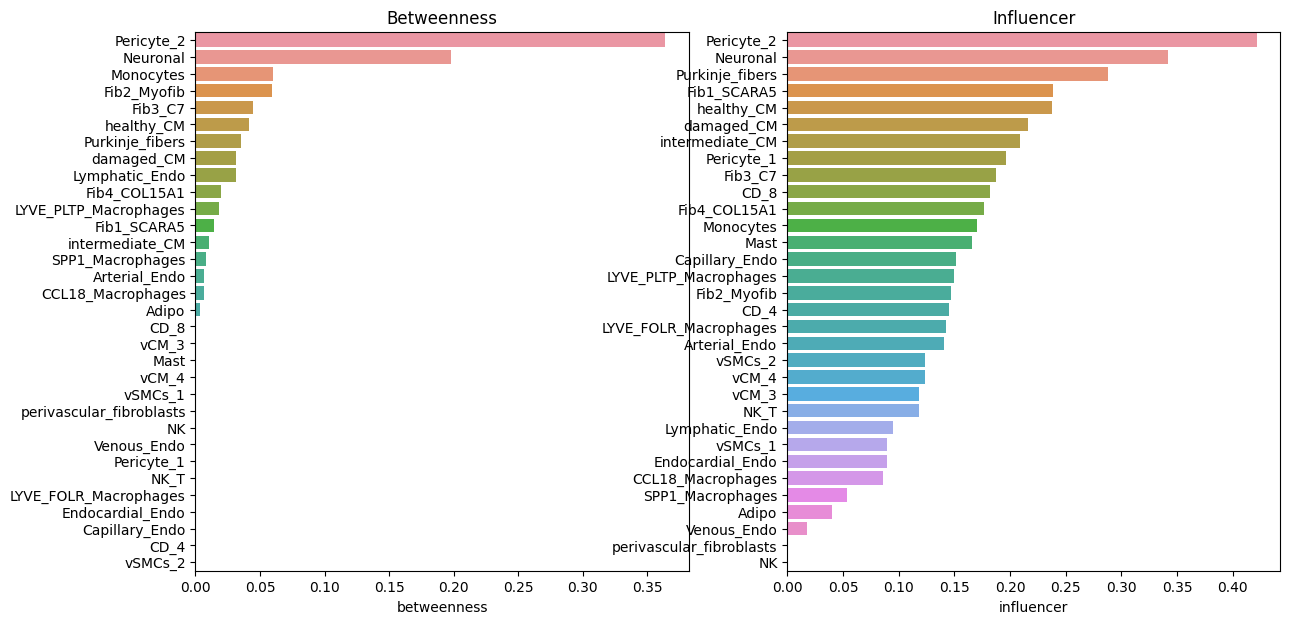

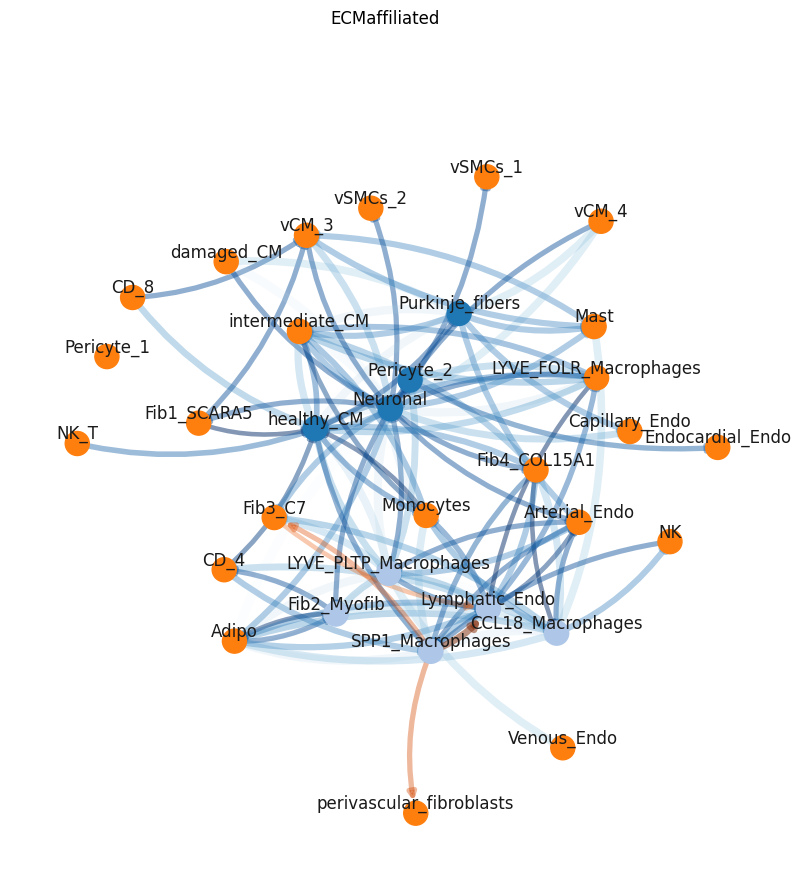

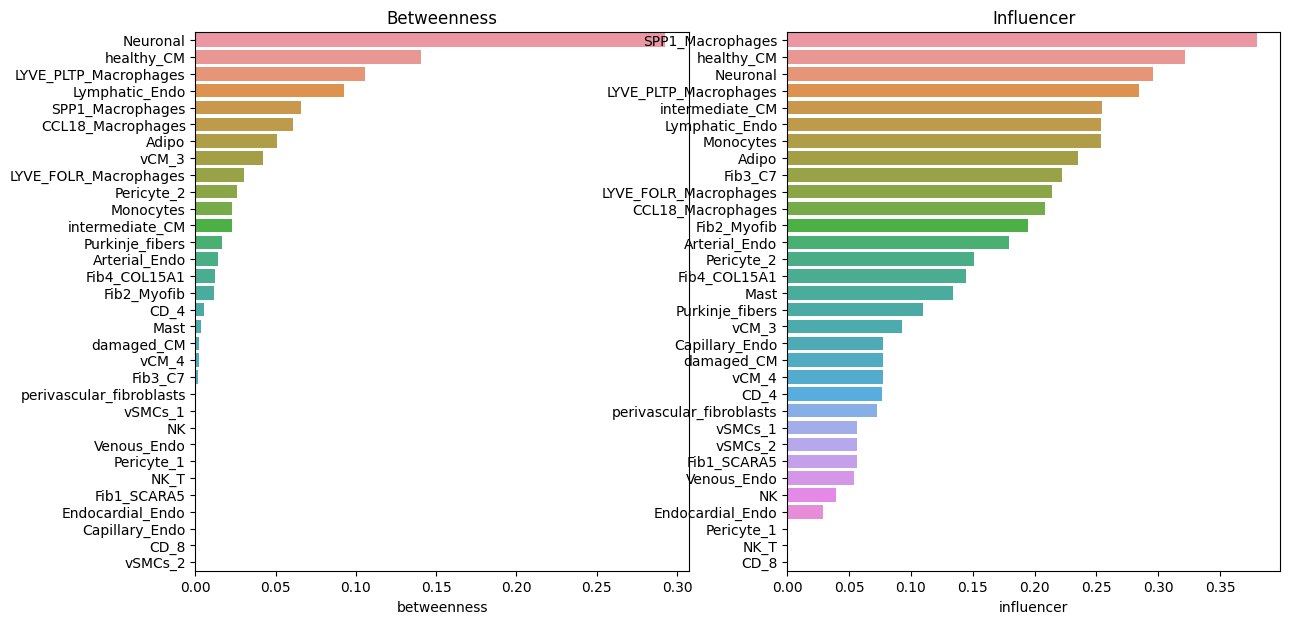

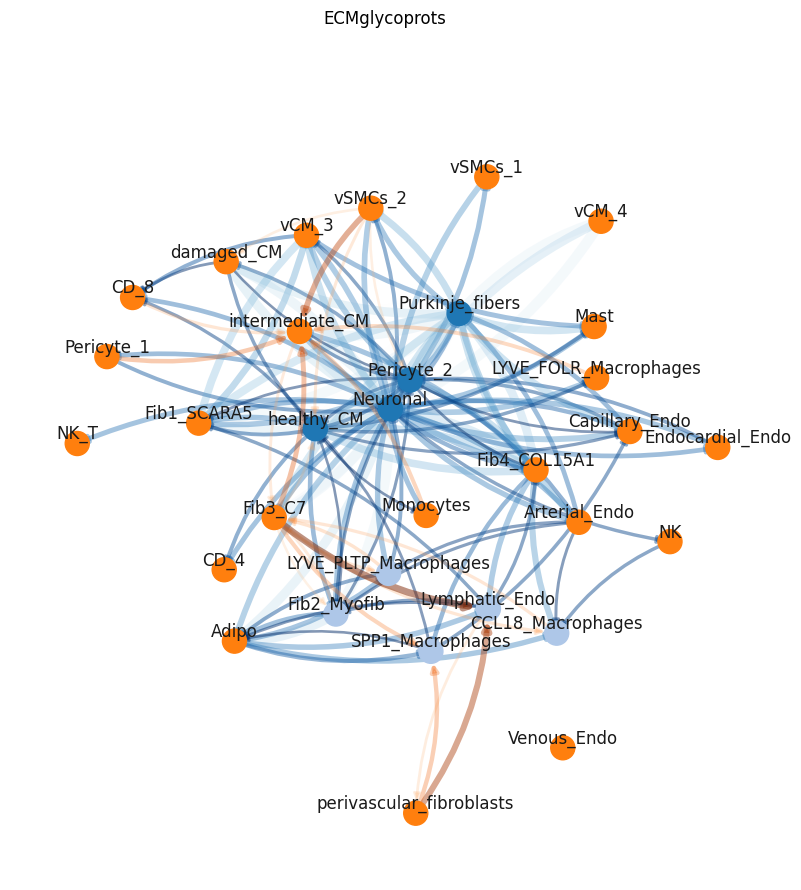

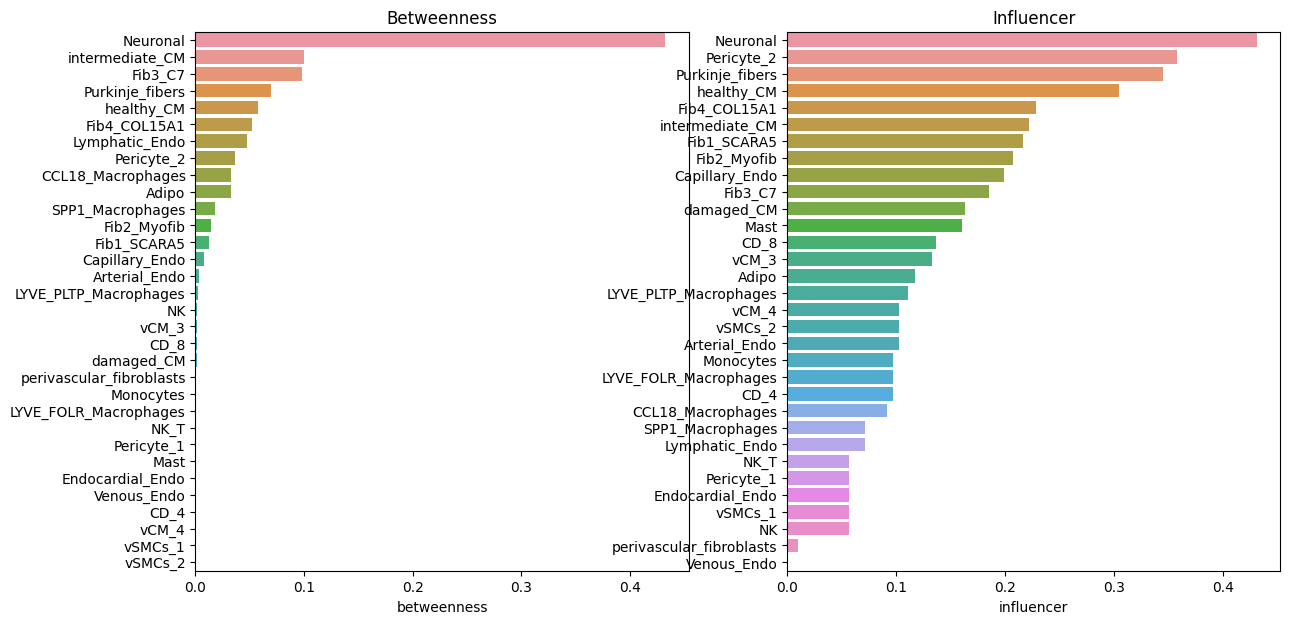

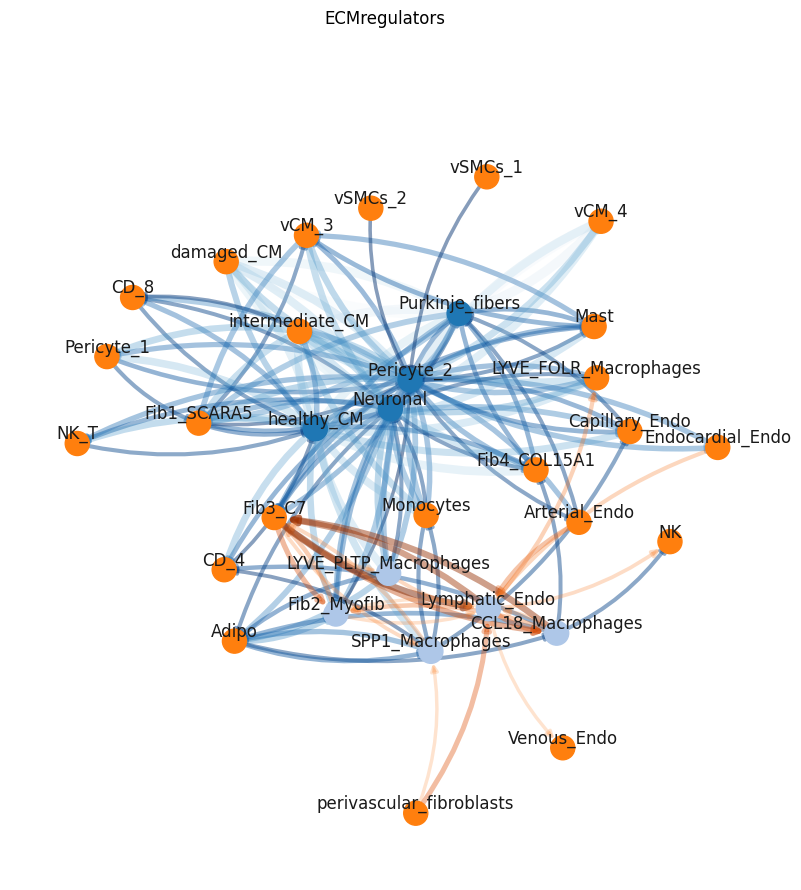

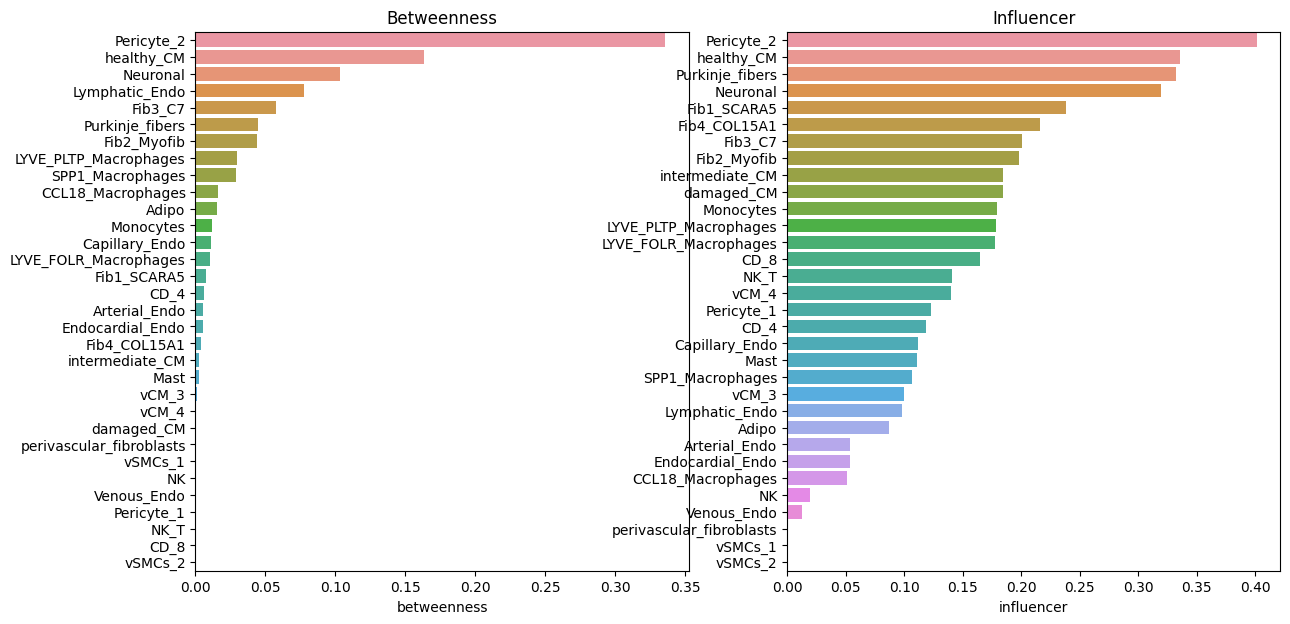

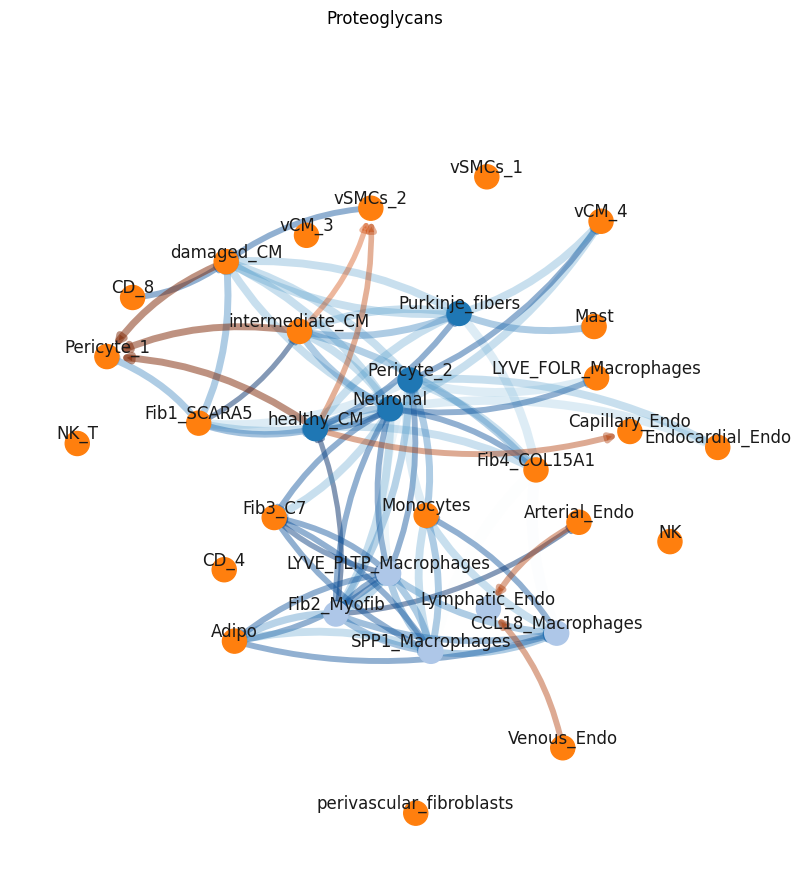

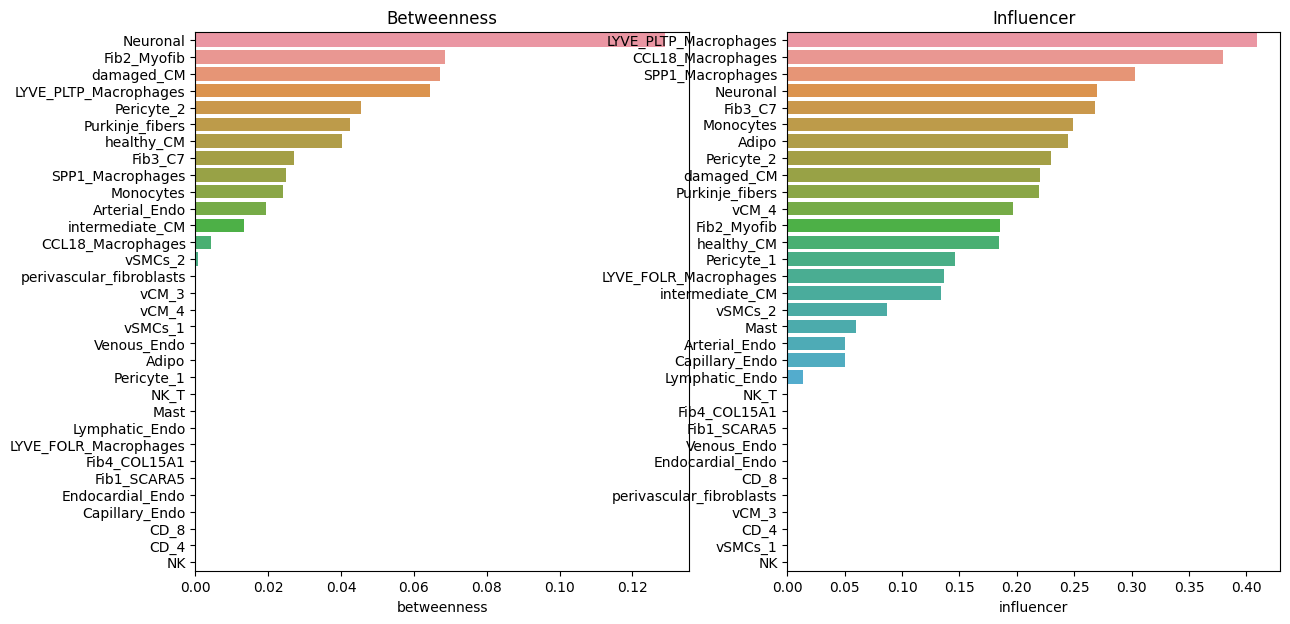

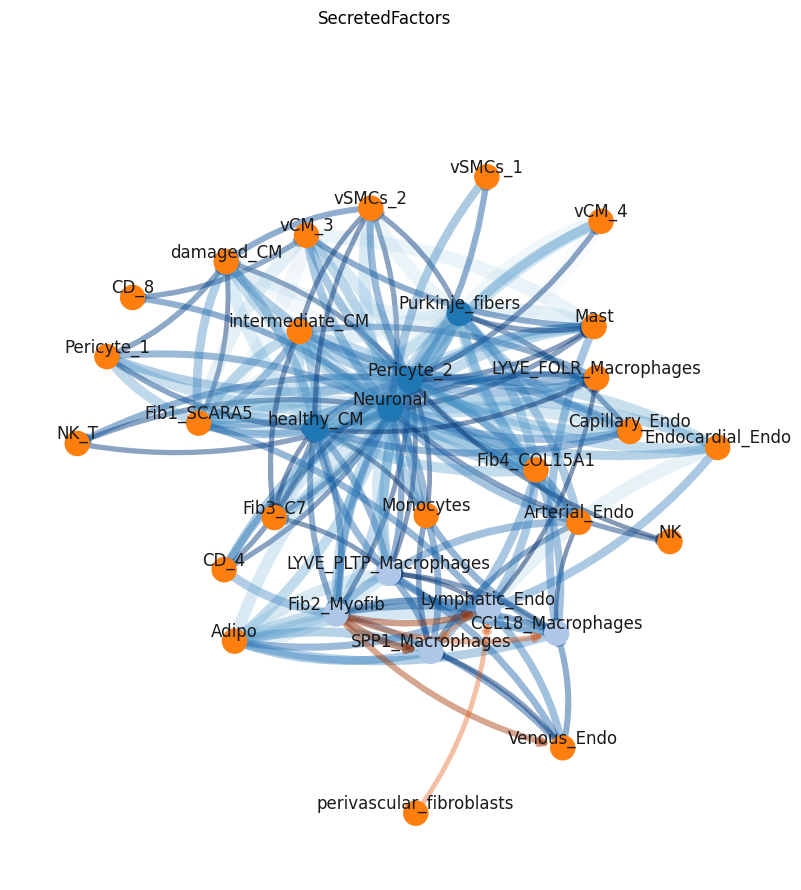

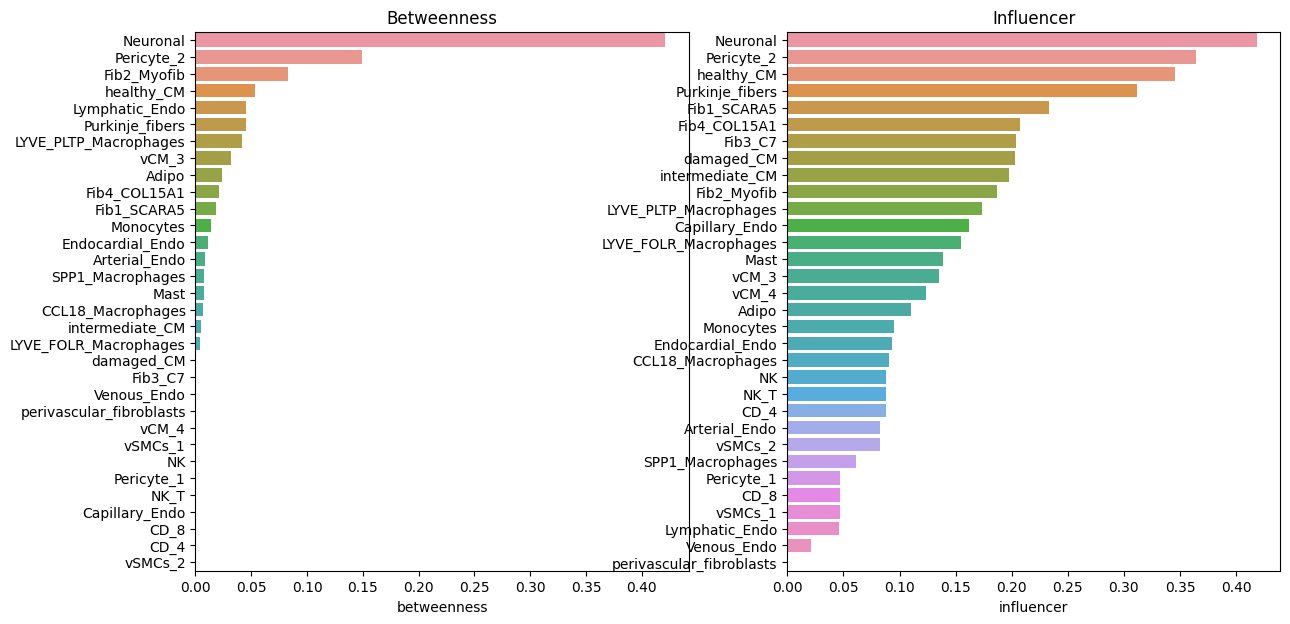

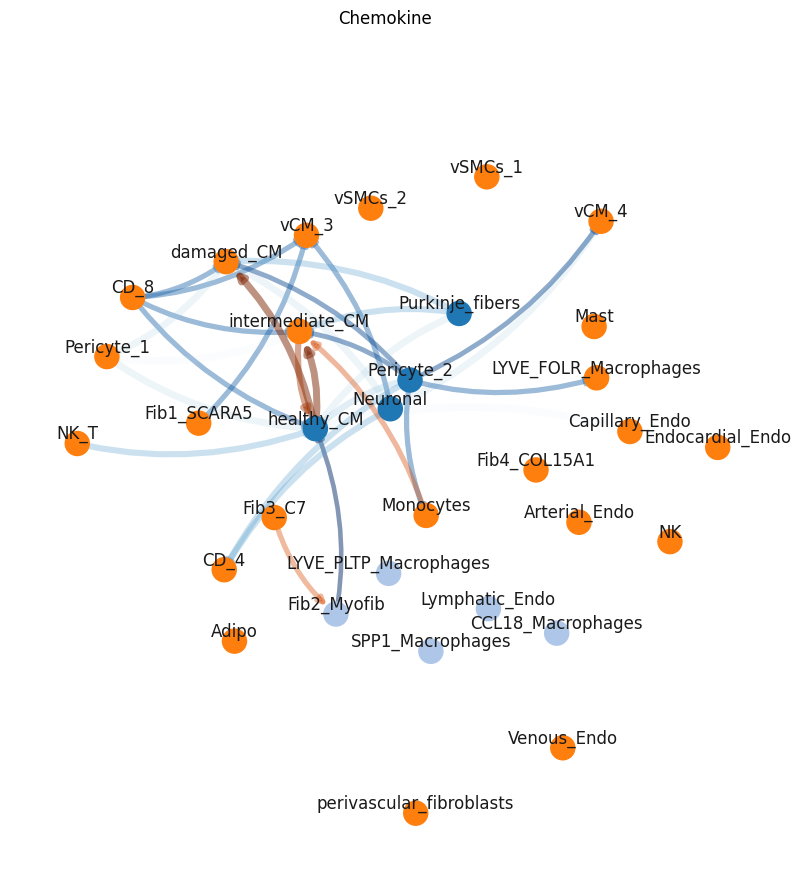

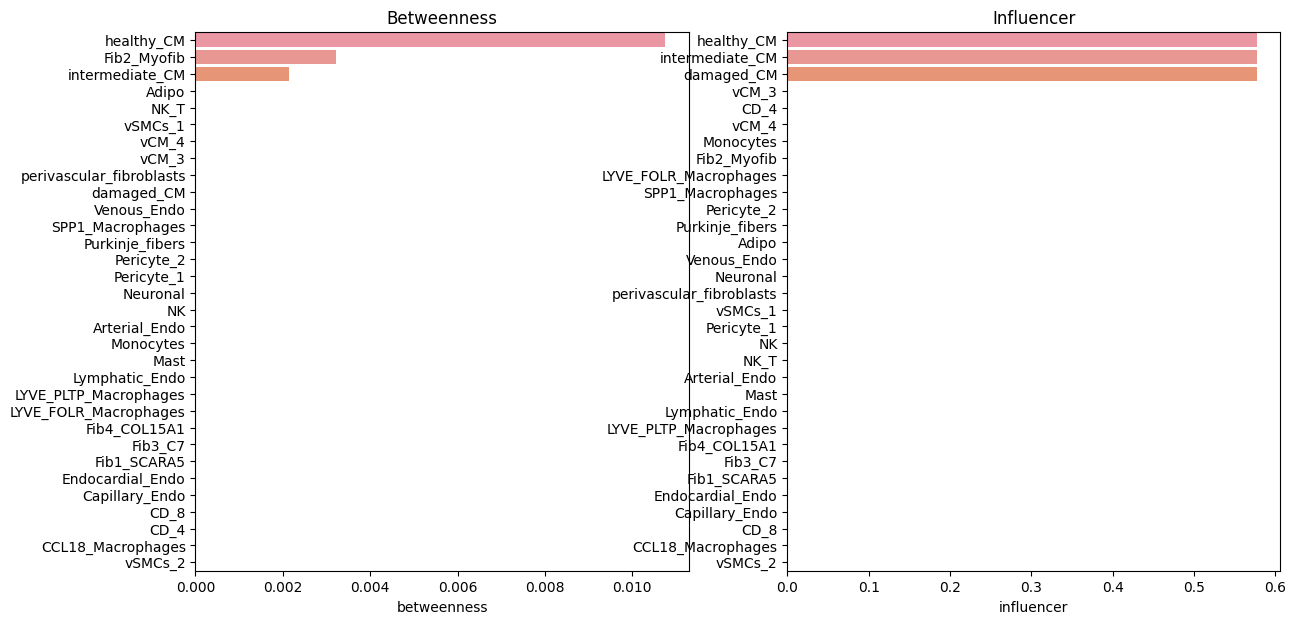

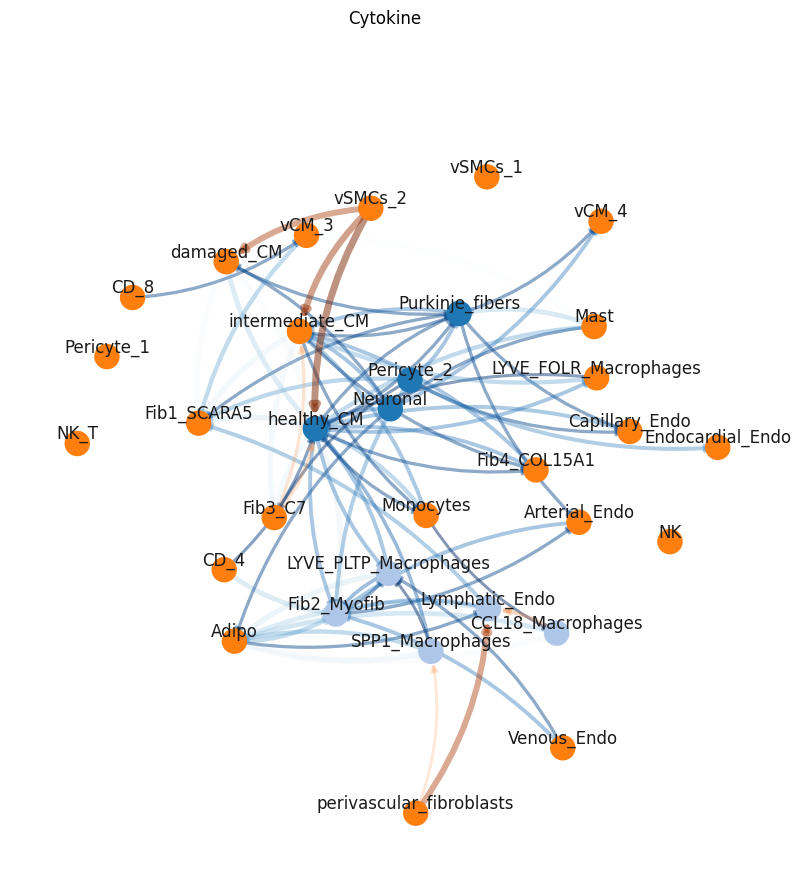

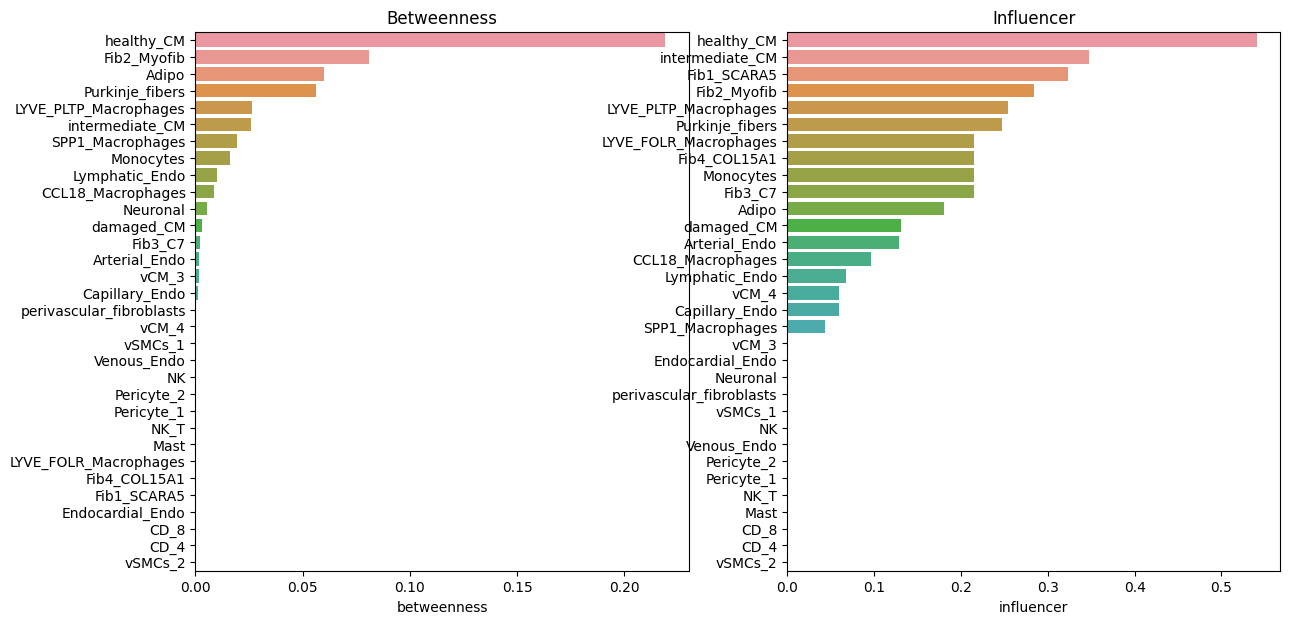

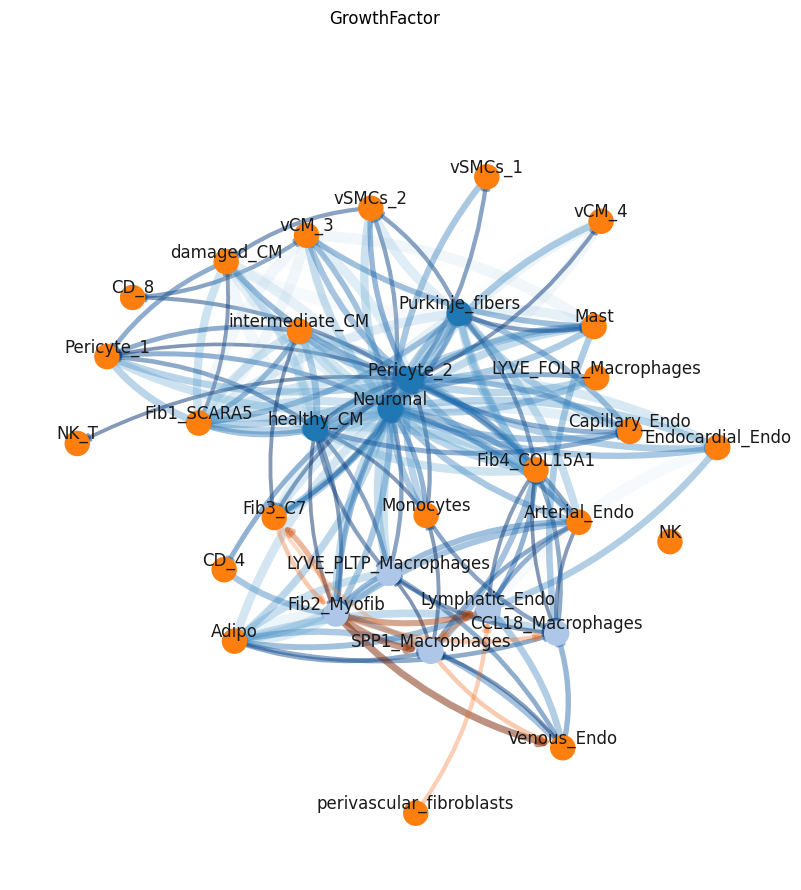

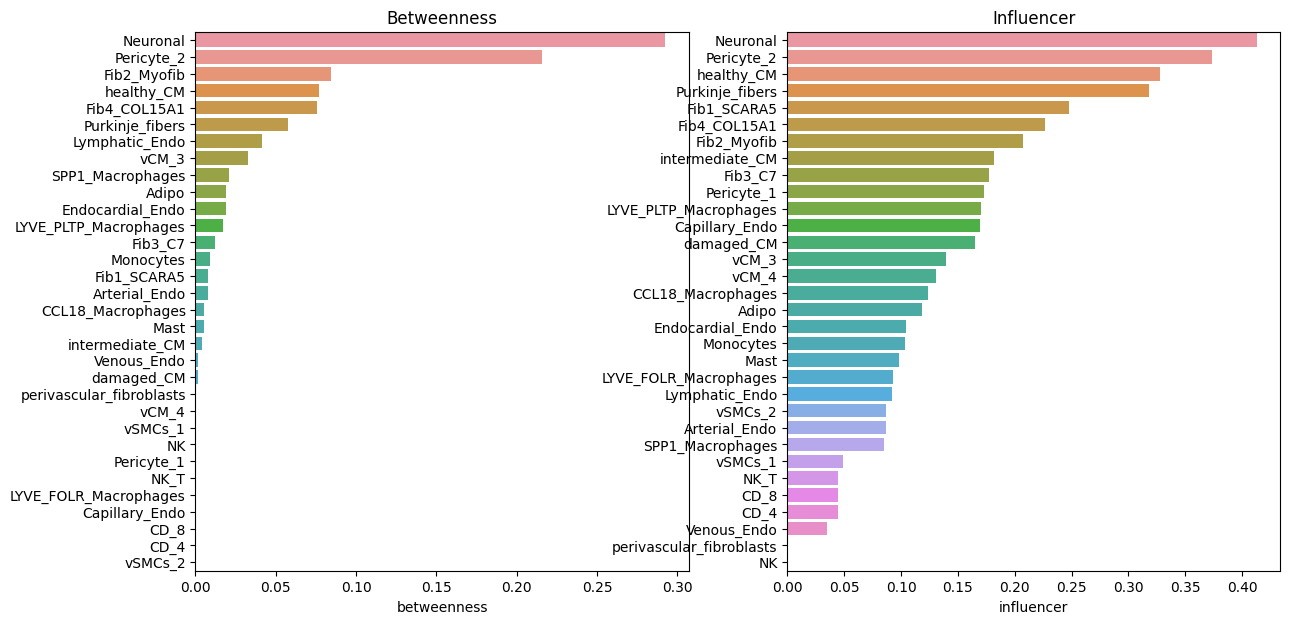

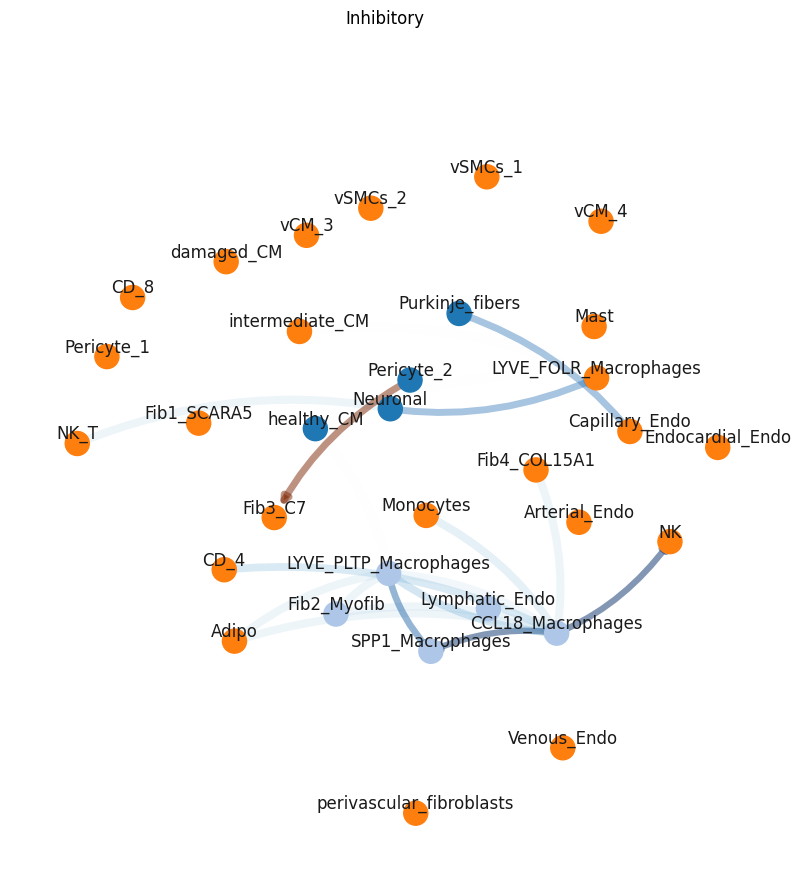

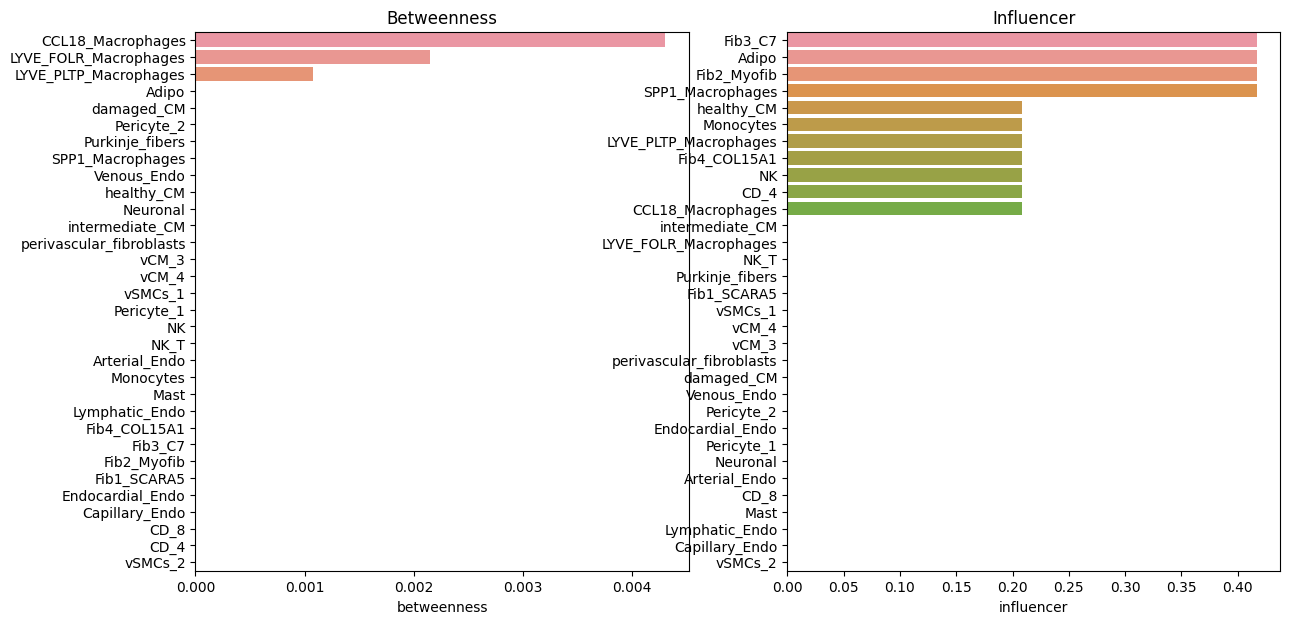

In [46]:
### Just one ligand category at a time
for cat in x_myoIsc2_dir.index:
    #we will first get a matrix of differential communication scores (x_chem) from a selected ligand category and the corresponding adjacency matrix (adjChem) 
    x_chem,adjChem=nichesphere.tl.getAdj_comm(diffCommTbl=x_myoIsc2_dir, pairCatDF=pairCatDFdir[pairCatDFdir.pairs.str.contains('prolif')==False], ncells=32, cat=cat, p=0.1)
    #Then we can plot the differential communication scores of that category in a heatmap
    #And visualize these ligand-receptor interactions as edges in the colocalisation network
    plt.style.use('default')
    plt.setp(plot.ax_heatmap.yaxis.get_majorticklabels(), rotation=1)
    #nichesphere.tl.catNW_test(x_chem=x_chem,colocNW=gCol, cell_group=cellGroups, group_cmap='tab20', ncols=20, plot_title=cat)
    G=nichesphere.tl.catNW(x_chem=x_chem,colocNW=gCol, cell_group=heatClusts_cellGroups, group_cmap='tab20', ncols=20, plot_title=cat)
    plt.show()
    
    t1=pd.DataFrame({'betweenness':[nx.betweenness_centrality(G)[x] for x in list(G.nodes)], 'influencer':[nx.eigenvector_centrality(G, max_iter=1000)[x] for x in list(G.nodes)],
                 'degree':[nx.degree_centrality(G)[x] for x in list(G.nodes)]})
    t1.index=list(G.nodes)
    plt.style.use('default')
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    sns.barplot(ax=axes[0], y=t1.sort_values('betweenness', ascending=False).index, x='betweenness', data=t1.sort_values('betweenness', ascending=False))
    axes[0].set_title('Betweenness')
    #sns.barplot(ax=axes[0], y=t1.sort_values('pagerank', ascending=False).index, x='pagerank', data=t1.sort_values('pagerank', ascending=False))
    #axes[0].set_title('Pagerank')
    sns.barplot(ax=axes[1], y=t1.sort_values('influencer', ascending=False).index, x='influencer', data=t1.sort_values('influencer', ascending=False))
    axes[1].set_title('Influencer')
    #plt.savefig('./figures/nwStats_'+cat+'.png')